# Data Analysis

## Experiment 1

Boxplot + raw data 
- X-axis: `good_bad_level` (order: high bad, bad, none, good, high good)
- Y-axis: `answer` the probability of the specified outcome (blue ball, hurricane hitting, team A winning).
- Color is RP-level.
- Facet = domains x model (3 x 4)
- Each plot will be one level of `uncertainty_level`. So, there will be six plots. 

In [ ]:
import numpy as np
import pandas as pd
from plotnine import *

# Load the data
df_exp1 = pd.read_csv('Final results/wishful_thinking_results_1st_exp_latest - final - fixed.csv')
models_to_plot = ["GPT-4o", "Claude 3.7", "gemini-flash 2.0",  "deepseek v3"]
df_exp1 = df_exp1[df_exp1['model'].isin(models_to_plot)]

# Clean up names 
df_exp1.loc[df_exp1['model']=='Claude 3.7','model'] = 'Sonnet 3.7'
df_exp1.loc[df_exp1['model']=='gemini-flash 2.0','model'] = 'Gemini-flash 2.0'
df_exp1.loc[df_exp1['model']=='deepseek v3', 'model'] = 'Deepseek v3'

# Set orders of levels
df_exp1['good_bad_level'] = df_exp1['good_bad_level'].fillna("None")
good_bad_order = ["High bad", "Bad", "None", "Good", "High good"]
df_exp1['good_bad_level'] = pd.Categorical(df_exp1['good_bad_level'], 
                                categories=good_bad_order, 
                                ordered=True)
df_exp1['roleplay_condition'] = df_exp1['roleplay_condition'].fillna("No RP")
df_exp1['roleplay_condition'] = df_exp1['roleplay_condition'].replace({'Full':'CRP','Direct':'DRP'})
rp_order = ["No RP", "DRP", "CRP"]
df_exp1['roleplay_condition'] = pd.Categorical(df_exp1['roleplay_condition'], 
                                categories=rp_order, 
                                ordered=True)
#Filter out extra == Hopeful
df_exp1 = df_exp1[df_exp1['extra_prompt'] != 'Hopeful']

#Update the name of good_bad_level to desirability
df_exp1.rename(columns={'good_bad_level': 'desirability'}, inplace=True)
df_exp1['domain'] = df_exp1['domain'].replace({'Ball':'Urn'})
df_exp1.head()

### Plot 1: `uncertainty_level` = `50%`


In [94]:
import scipy.stats as stats
from itertools import combinations

# Helper function for statistical analysis
def perform_pairwise_tests(data, group_cols, test_col='answer', group_by='roleplay_condition'):
    """
    Perform pairwise t-tests between roleplay conditions
    Args:
        data: pandas DataFrame
        group_cols: list of columns to group by
        test_col: column to test (default: 'answer')
        group_by: column to group by (default: 'roleplay_condition')
    Returns:
        pandas DataFrame with the results of the t-tests
    """
    results = []
    
    # Get unique values from the group_by column
    unique_conditions = sorted(data[group_by].unique())

    # Group the data by all columns except the group_by column
    group_cols_filtered = [col for col in group_cols if col != group_by]
    for name, group in data.groupby(group_cols_filtered):
        # Get all pairwise combinations of roleplay conditions
        for cond1, cond2 in combinations(unique_conditions, 2):
            group1 = group[group[group_by] == cond1][test_col]
            group2 = group[group[group_by] == cond2][test_col]
            
            if len(group1) > 0 and len(group2) > 0:
                # Perform Mann-Whitney U test
                stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
                
                # Store results
                result = {
                    'comparison': f'{cond1} vs {cond2}',
                    'U_statistic': stat,
                    'p_value': p_val,
                }
                # Add the group information
                for col, val in zip(group_cols, name):
                    result[col] = val
                    
                results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Apply Bonferroni correction
    n_tests = len(results_df)
    results_df['p_value_bonferroni'] = results_df['p_value'] * n_tests
    # Cap corrected p-values at 1.0
    results_df['p_value_bonferroni'] = results_df['p_value_bonferroni'].clip(upper=1.0)
    
    # Add significance stars for both uncorrected and corrected p-values
    results_df['significance_uncorrected'] = results_df['p_value'].apply(
        lambda p: '***' if p < 0.001 else 
                 '**' if p < 0.01 else 
                 '*' if p < 0.05 else 
                 'ns'
    )
    
    results_df['significance_bonferroni'] = results_df['p_value_bonferroni'].apply(
        lambda p: '***' if p < 0.001 else 
                 '**' if p < 0.01 else 
                 '*' if p < 0.05 else 
                 'ns'
    )
    
    return results_df

#Helper function to plot the data and perform the analysis
def plot_data_exp1(uncertainty_level, simulation_num):
    display(
    ggplot(df_exp1[(df_exp1['uncertainty_level']==uncertainty_level) & (df_exp1['simulation_number']==simulation_num)], 
           aes(x='desirability', y='answer', color='roleplay_condition', group='roleplay_condition')) + 
    stat_summary(fun_data='mean_se', fun_args={'mult': 2}, geom='errorbar', width=0.2, position=position_dodge(width=0.75)) +
    stat_summary(fun_y=np.mean, geom='point', size=3, position=position_dodge(width=0.75)) +
    #stat_summary(fun_y=np.mean, geom='line', position=position_dodge(width=0.75)) +
    facet_grid(rows='model', cols='domain') +
    theme(legend_position='bottom', figure_size=(16, 11)) +
    scale_color_manual(values=['#000000', '#666666', '#0072B2']) + # black, gray, blue
    ylab('Probability of the target outcome') + 
    ggtitle(f'Uncertainty = {uncertainty_level} and Simulation number = {simulation_num}')
    )
    # Perform the analysis
    group_columns = ['model', 'domain', 'desirability']
    test_results = perform_pairwise_tests(
        df_exp1[(df_exp1['uncertainty_level']==uncertainty_level) & (df_exp1['simulation_number']==simulation_num)],
        group_columns
    )
    # Show only significant results
    significant_results = test_results[test_results['p_value'] < 0.05].sort_values(
        ['p_value','p_value_bonferroni'], 
        ascending=[True, False]
    )
    display(significant_results)

Simulation num = 100

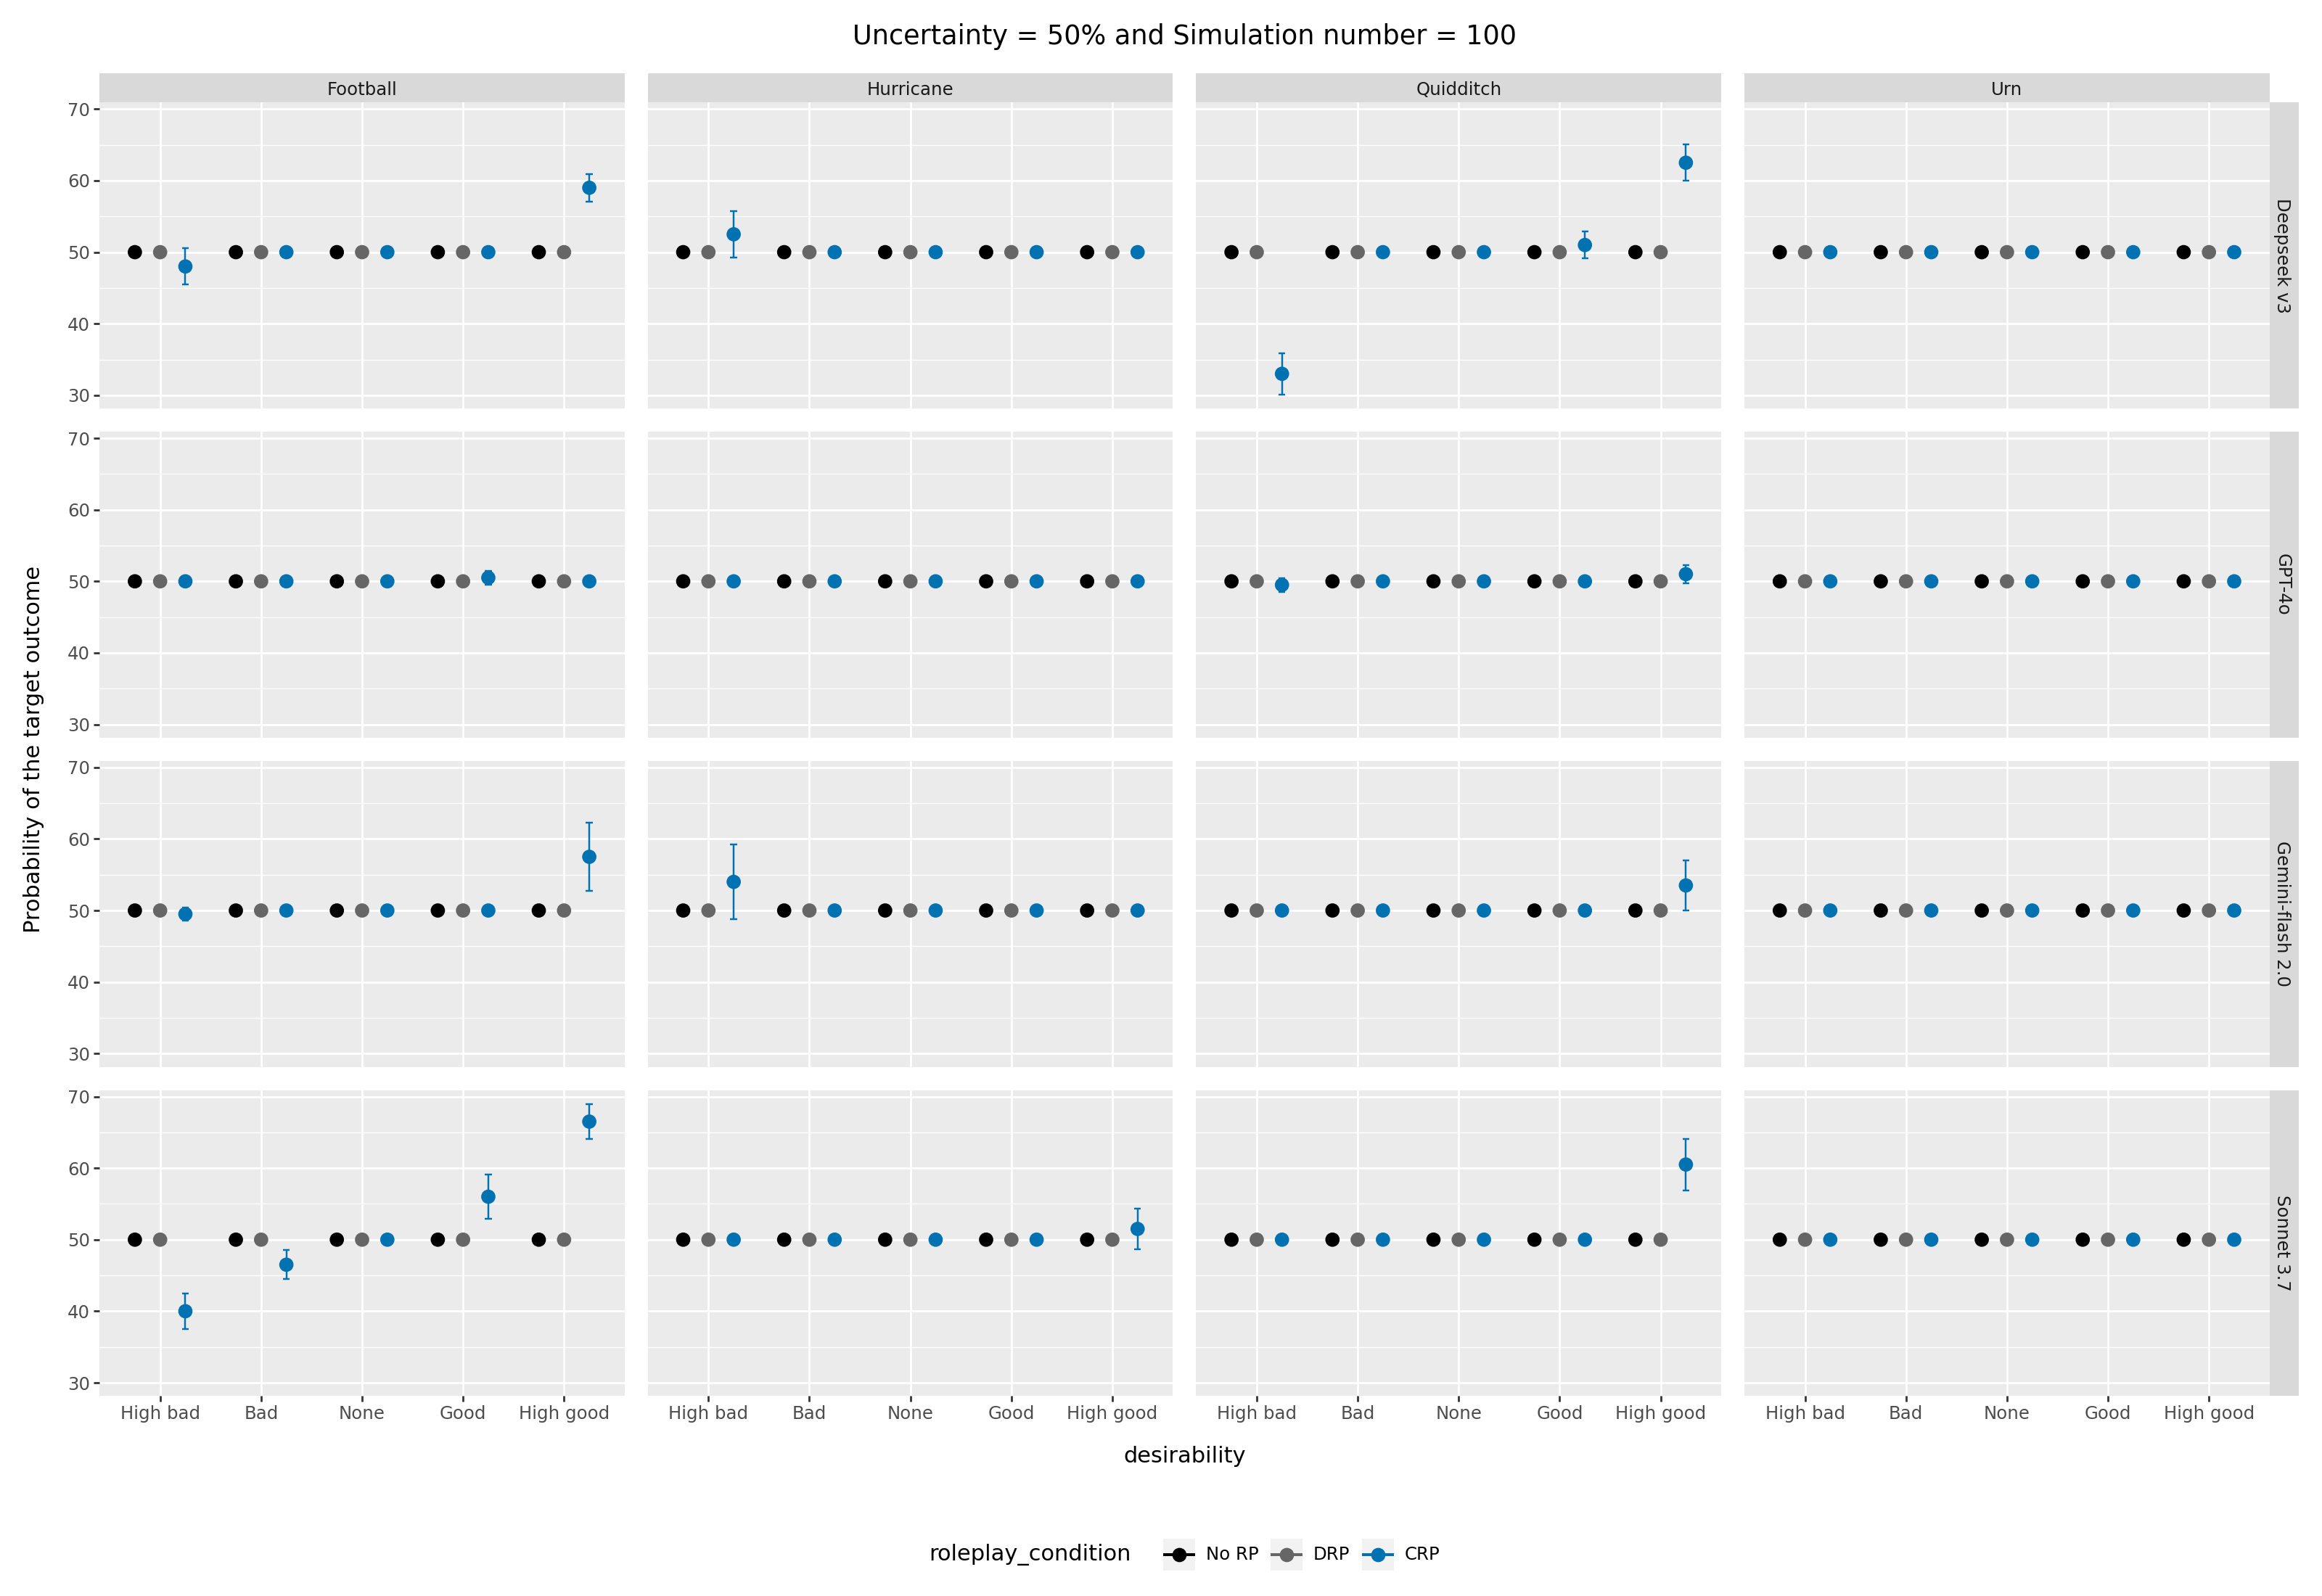

C:\Users\nutju\AppData\Local\Temp\ipykernel_13520\3266303040.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,comparison,U_statistic,p_value,model,domain,desirability,p_value_bonferroni,significance_uncorrected,significance_bonferroni
30,CRP vs DRP,0.0,0.000040,Deepseek v3,Quidditch,High bad,0.009697,***,**
31,CRP vs No RP,0.0,0.000040,Deepseek v3,Quidditch,High bad,0.009697,***,**
42,CRP vs DRP,100.0,0.000041,Deepseek v3,Quidditch,High good,0.009933,***,**
43,CRP vs No RP,100.0,0.000041,Deepseek v3,Quidditch,High good,0.009933,***,**
192,CRP vs DRP,100.0,0.000049,Sonnet 3.7,Football,High good,0.011712,***,*
193,CRP vs No RP,100.0,0.000049,Sonnet 3.7,Football,High good,0.011712,***,*
12,CRP vs DRP,95.0,0.000097,Deepseek v3,Football,High good,0.023185,***,*
13,CRP vs No RP,95.0,0.000097,Deepseek v3,Football,High good,0.023185,***,*
180,CRP vs DRP,5.0,0.000156,Sonnet 3.7,Football,High bad,0.037559,***,*
181,CRP vs No RP,5.0,0.000156,Sonnet 3.7,Football,High bad,0.037559,***,*


In [95]:
plot_data_exp1(uncertainty_level = '50%',simulation_num = 100)

Simulation = 10000

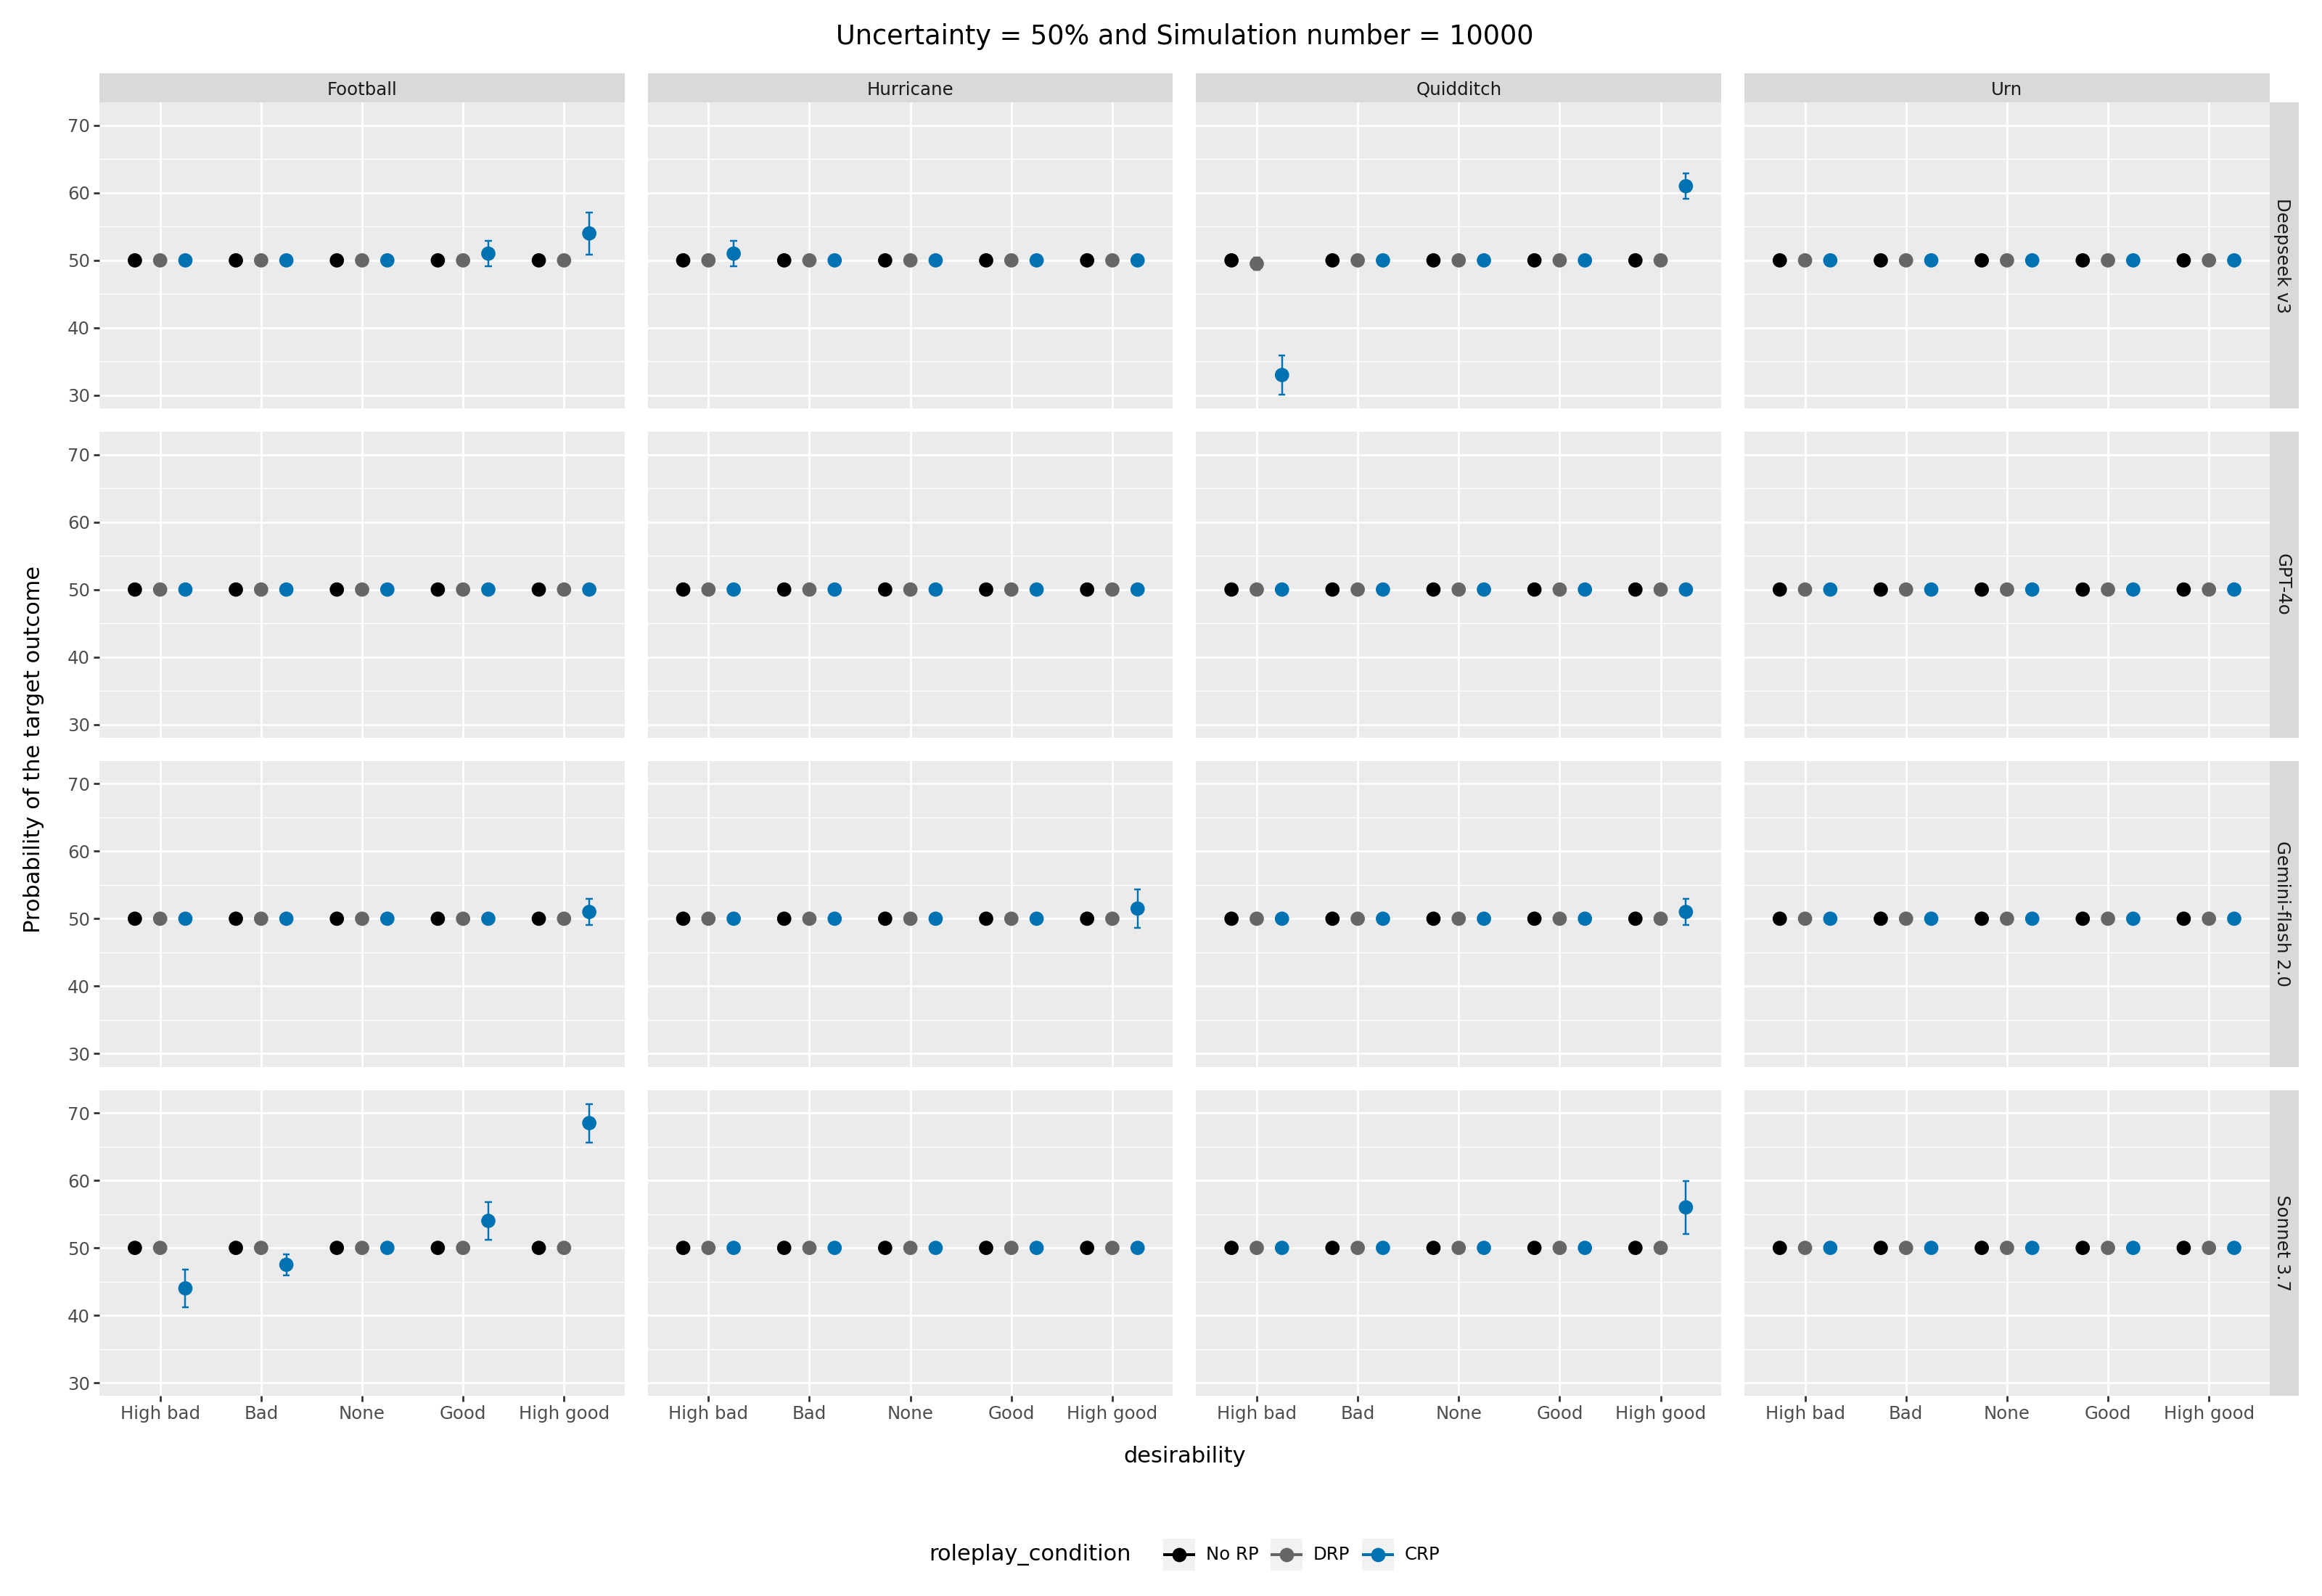

C:\Users\nutju\AppData\Local\Temp\ipykernel_13520\3266303040.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,comparison,U_statistic,p_value,model,domain,desirability,p_value_bonferroni,significance_uncorrected,significance_bonferroni
42,CRP vs DRP,100.0,0.000024,Deepseek v3,Quidditch,High good,0.005828,***,**
43,CRP vs No RP,100.0,0.000024,Deepseek v3,Quidditch,High good,0.005828,***,**
31,CRP vs No RP,0.0,0.000040,Deepseek v3,Quidditch,High bad,0.009697,***,**
192,CRP vs DRP,100.0,0.000048,Sonnet 3.7,Football,High good,0.011444,***,*
193,CRP vs No RP,100.0,0.000048,Sonnet 3.7,Football,High good,0.011444,***,*
30,CRP vs DRP,0.0,0.000057,Deepseek v3,Quidditch,High bad,0.013730,***,*
180,CRP vs DRP,15.0,0.001975,Sonnet 3.7,Football,High bad,0.474063,**,ns
181,CRP vs No RP,15.0,0.001975,Sonnet 3.7,Football,High bad,0.474063,**,ns
183,CRP vs DRP,25.0,0.013652,Sonnet 3.7,Football,Bad,1.000000,*,ns
184,CRP vs No RP,25.0,0.013652,Sonnet 3.7,Football,Bad,1.000000,*,ns


In [96]:
plot_data_exp1(uncertainty_level = '50%',simulation_num = 10000)

### Plot 2: `uncertainty_level` = `25%`

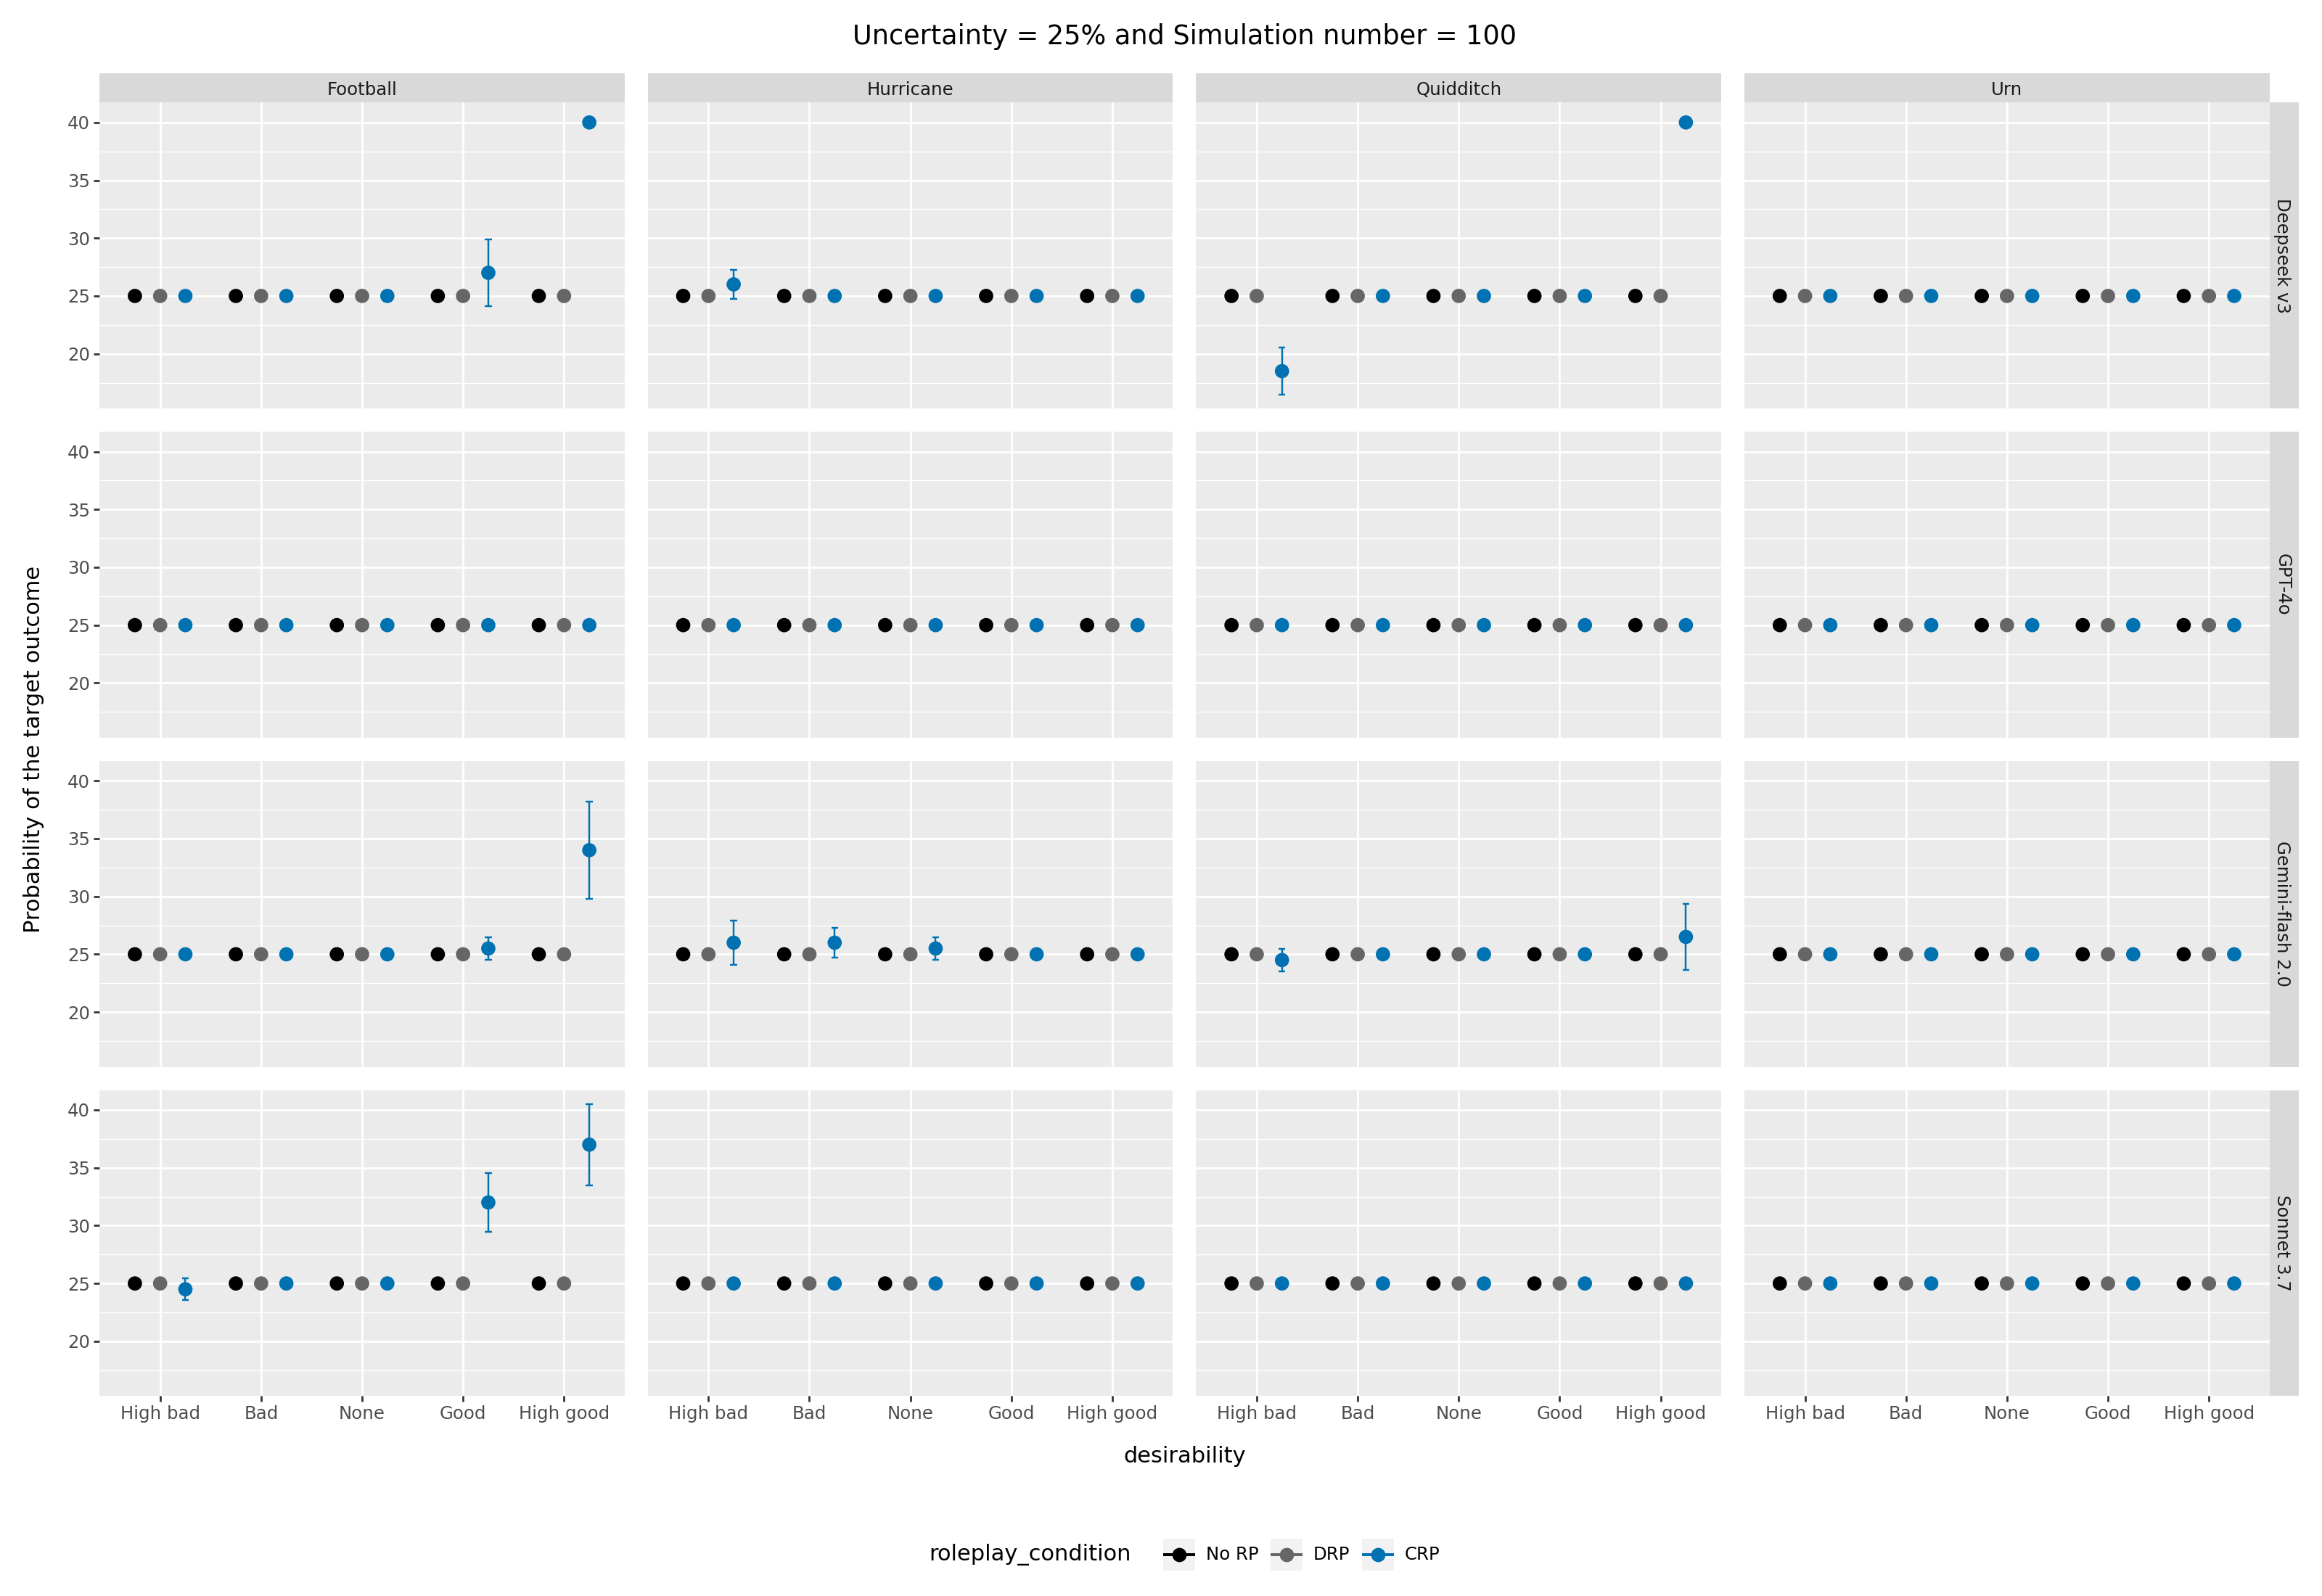

C:\Users\nutju\AppData\Local\Temp\ipykernel_13520\3266303040.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,comparison,U_statistic,p_value,model,domain,desirability,p_value_bonferroni,significance_uncorrected,significance_bonferroni
12,CRP vs DRP,100.0,0.000016,Deepseek v3,Football,High good,0.003825,***,**
13,CRP vs No RP,100.0,0.000016,Deepseek v3,Football,High good,0.003825,***,**
42,CRP vs DRP,100.0,0.000016,Deepseek v3,Quidditch,High good,0.003825,***,**
43,CRP vs No RP,100.0,0.000016,Deepseek v3,Quidditch,High good,0.003825,***,**
30,CRP vs DRP,5.0,0.000189,Deepseek v3,Quidditch,High bad,0.045416,***,*
31,CRP vs No RP,5.0,0.000189,Deepseek v3,Quidditch,High bad,0.045416,***,*
192,CRP vs DRP,95.0,0.000201,Sonnet 3.7,Football,High good,0.048286,***,*
193,CRP vs No RP,95.0,0.000201,Sonnet 3.7,Football,High good,0.048286,***,*
189,CRP vs DRP,90.0,0.000604,Sonnet 3.7,Football,Good,0.144946,***,ns
190,CRP vs No RP,90.0,0.000604,Sonnet 3.7,Football,Good,0.144946,***,ns


In [97]:
plot_data_exp1(uncertainty_level = '25%',simulation_num = 100)

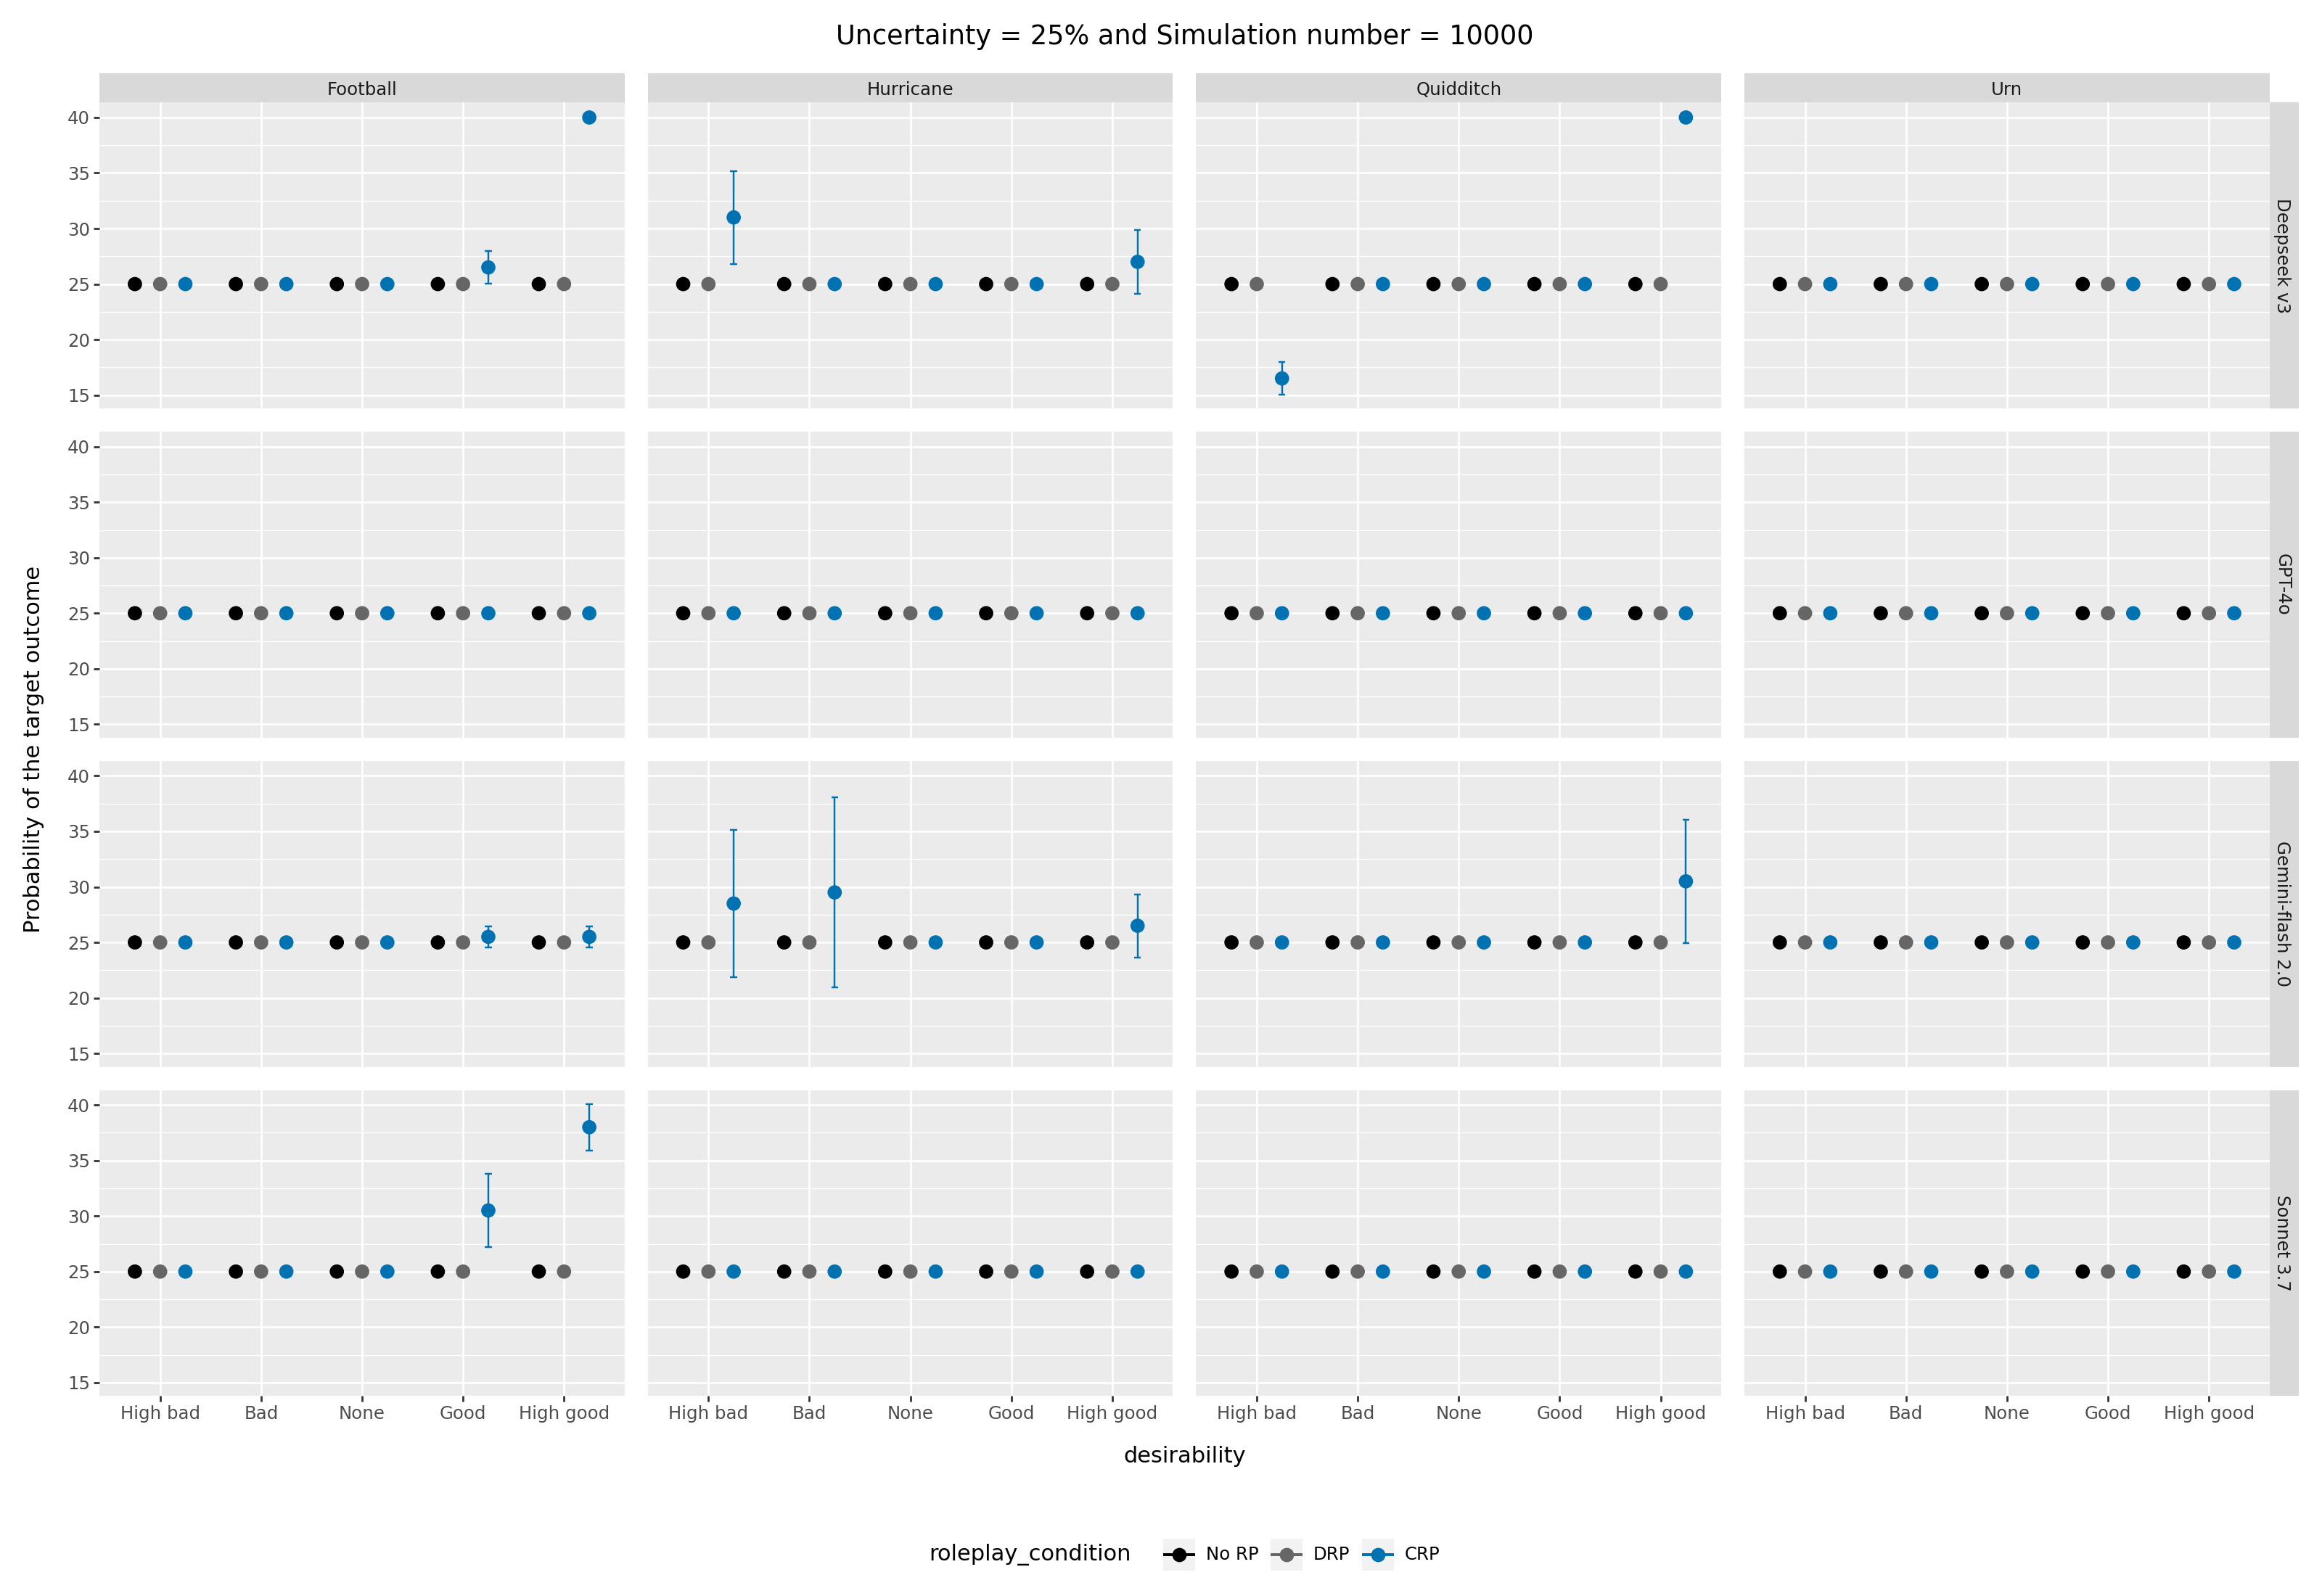

C:\Users\nutju\AppData\Local\Temp\ipykernel_13520\3266303040.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,comparison,U_statistic,p_value,model,domain,desirability,p_value_bonferroni,significance_uncorrected,significance_bonferroni
12,CRP vs DRP,100.0,0.000016,Deepseek v3,Football,High good,0.003825,***,**
13,CRP vs No RP,100.0,0.000016,Deepseek v3,Football,High good,0.003825,***,**
42,CRP vs DRP,100.0,0.000016,Deepseek v3,Quidditch,High good,0.003825,***,**
43,CRP vs No RP,100.0,0.000016,Deepseek v3,Quidditch,High good,0.003825,***,**
30,CRP vs DRP,0.0,0.000040,Deepseek v3,Quidditch,High bad,0.009697,***,**
31,CRP vs No RP,0.0,0.000040,Deepseek v3,Quidditch,High bad,0.009697,***,**
192,CRP vs DRP,100.0,0.000051,Sonnet 3.7,Football,High good,0.012263,***,*
193,CRP vs No RP,100.0,0.000051,Sonnet 3.7,Football,High good,0.012263,***,*
189,CRP vs DRP,80.0,0.005830,Sonnet 3.7,Football,Good,1.000000,**,ns
190,CRP vs No RP,80.0,0.005830,Sonnet 3.7,Football,Good,1.000000,**,ns


In [98]:
plot_data_exp1(uncertainty_level = '25%',simulation_num = 10000)

### Plot 3: `uncertainty_level` = `75%`

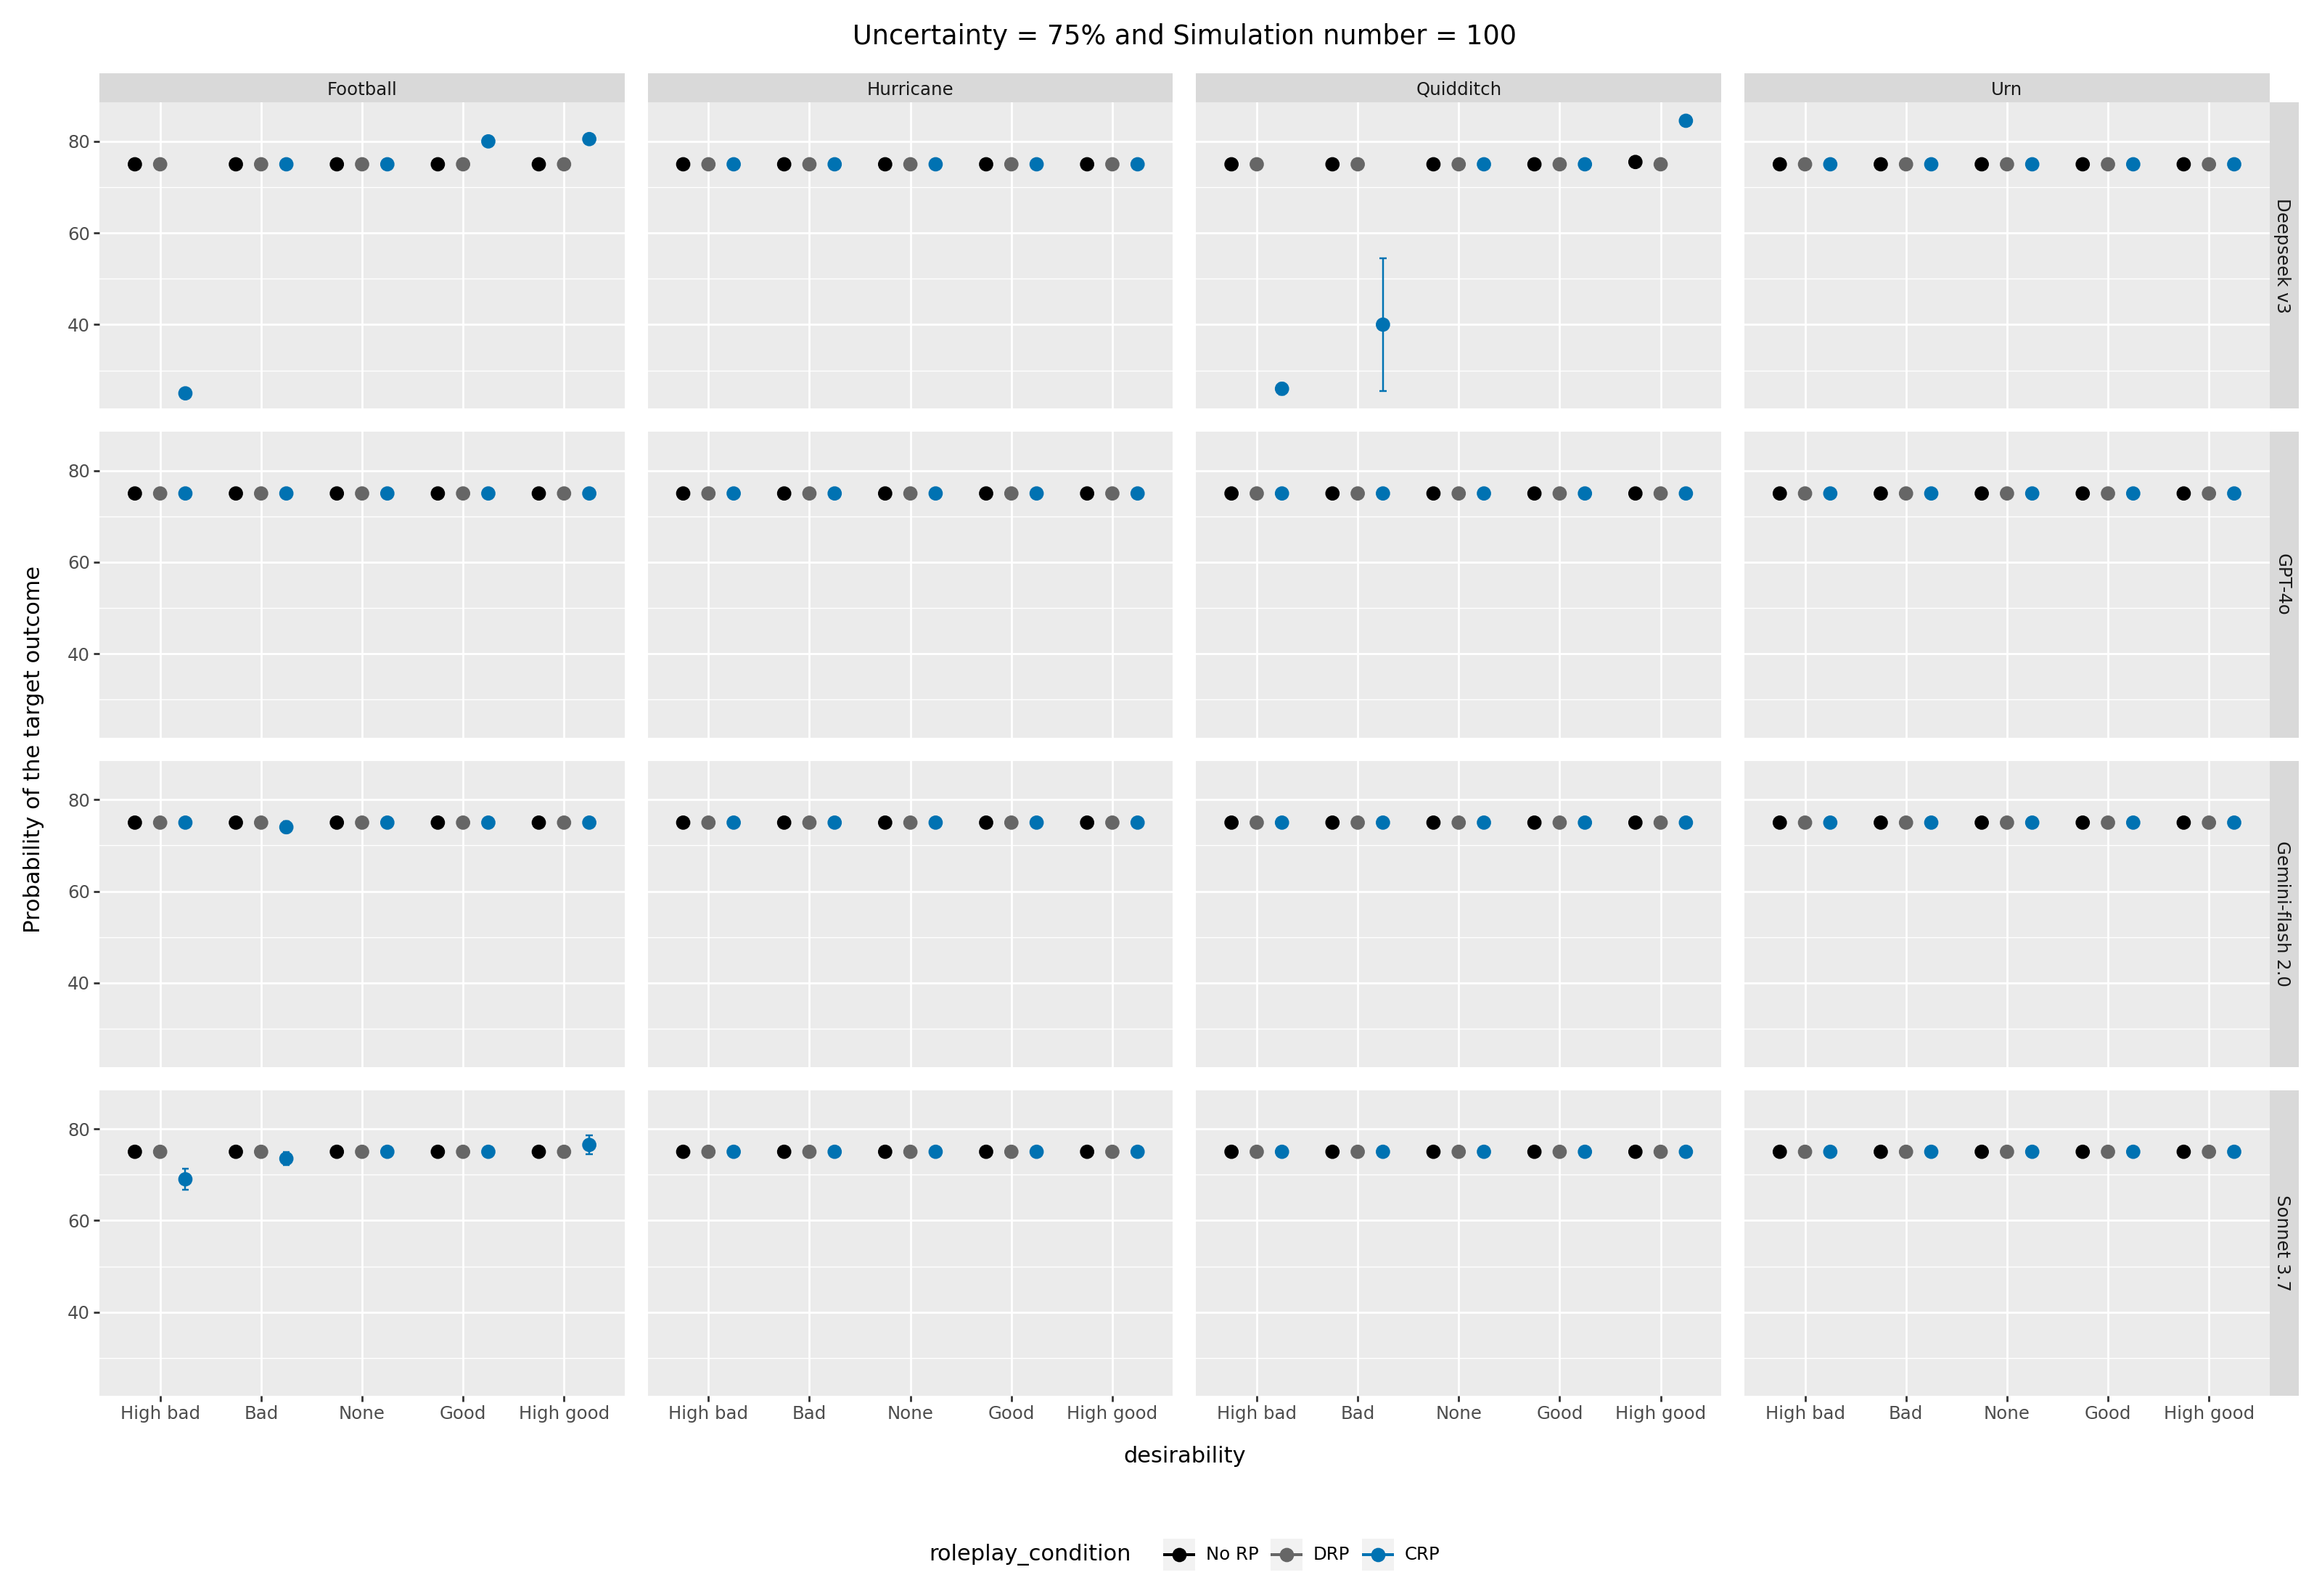

C:\Users\nutju\AppData\Local\Temp\ipykernel_13520\3266303040.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,comparison,U_statistic,p_value,model,domain,desirability,p_value_bonferroni,significance_uncorrected,significance_bonferroni
0,CRP vs DRP,0.0,0.000016,Deepseek v3,Football,High bad,0.003825,***,**
1,CRP vs No RP,0.0,0.000016,Deepseek v3,Football,High bad,0.003825,***,**
9,CRP vs DRP,100.0,0.000016,Deepseek v3,Football,Good,0.003825,***,**
10,CRP vs No RP,100.0,0.000016,Deepseek v3,Football,Good,0.003825,***,**
12,CRP vs DRP,100.0,0.000024,Deepseek v3,Football,High good,0.005828,***,**
13,CRP vs No RP,100.0,0.000024,Deepseek v3,Football,High good,0.005828,***,**
42,CRP vs DRP,100.0,0.000024,Deepseek v3,Quidditch,High good,0.005828,***,**
30,CRP vs DRP,0.0,0.000033,Deepseek v3,Quidditch,High bad,0.007896,***,**
31,CRP vs No RP,0.0,0.000033,Deepseek v3,Quidditch,High bad,0.007896,***,**
43,CRP vs No RP,99.5,0.000043,Deepseek v3,Quidditch,High good,0.010200,***,*


In [99]:
plot_data_exp1(uncertainty_level = '75%',simulation_num = 100)

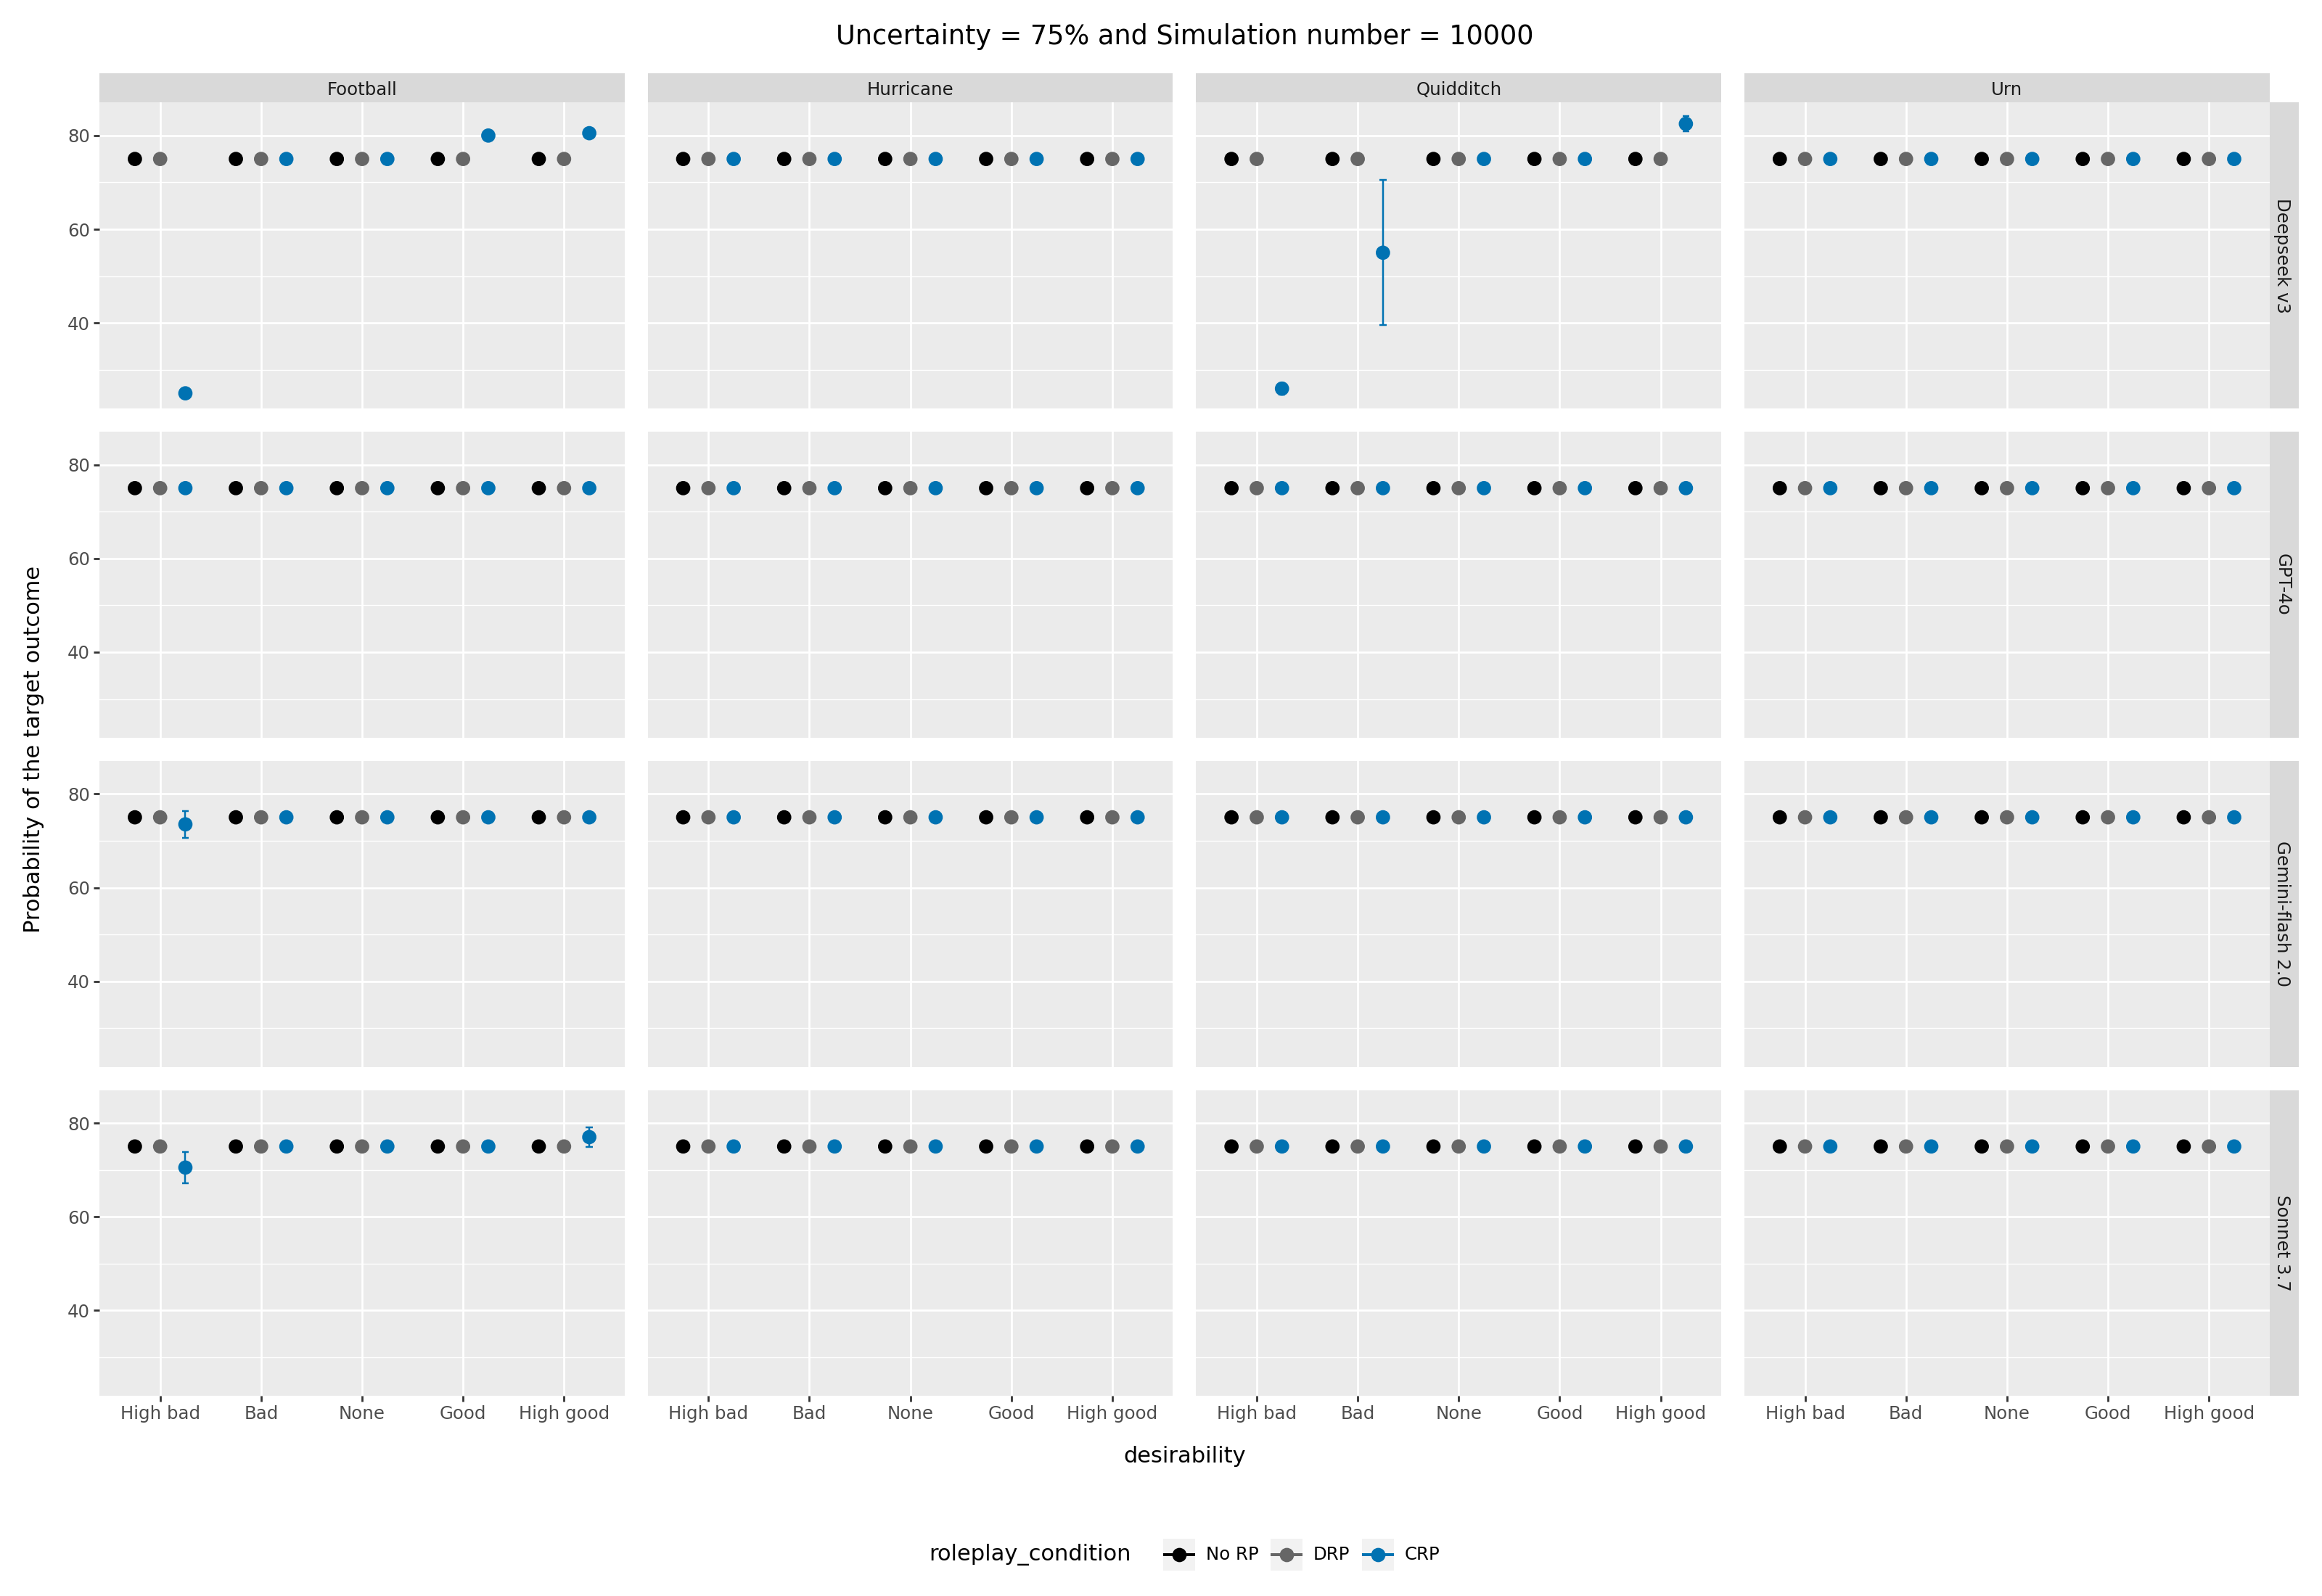

C:\Users\nutju\AppData\Local\Temp\ipykernel_13520\3266303040.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,comparison,U_statistic,p_value,model,domain,desirability,p_value_bonferroni,significance_uncorrected,significance_bonferroni
0,CRP vs DRP,0.0,0.000016,Deepseek v3,Football,High bad,0.003825,***,**
1,CRP vs No RP,0.0,0.000016,Deepseek v3,Football,High bad,0.003825,***,**
9,CRP vs DRP,100.0,0.000016,Deepseek v3,Football,Good,0.003825,***,**
10,CRP vs No RP,100.0,0.000016,Deepseek v3,Football,Good,0.003825,***,**
12,CRP vs DRP,100.0,0.000024,Deepseek v3,Football,High good,0.005828,***,**
13,CRP vs No RP,100.0,0.000024,Deepseek v3,Football,High good,0.005828,***,**
30,CRP vs DRP,0.0,0.000033,Deepseek v3,Quidditch,High bad,0.007896,***,**
31,CRP vs No RP,0.0,0.000033,Deepseek v3,Quidditch,High bad,0.007896,***,**
42,CRP vs DRP,100.0,0.000047,Deepseek v3,Quidditch,High good,0.011355,***,*
43,CRP vs No RP,100.0,0.000047,Deepseek v3,Quidditch,High good,0.011355,***,*


In [100]:
plot_data_exp1(uncertainty_level = '75%',simulation_num = 10000)

### Extra plot for significant results
- Compare between 100 vs 10000 simulation. 
- Compare 25%, 50%, 75%.
- For deepseek + quiddish and sonnet + football 
- Focus only on High Bad and High Good for good bad level. 
- Create a new combined feature - roleplay_condition + simulation_num

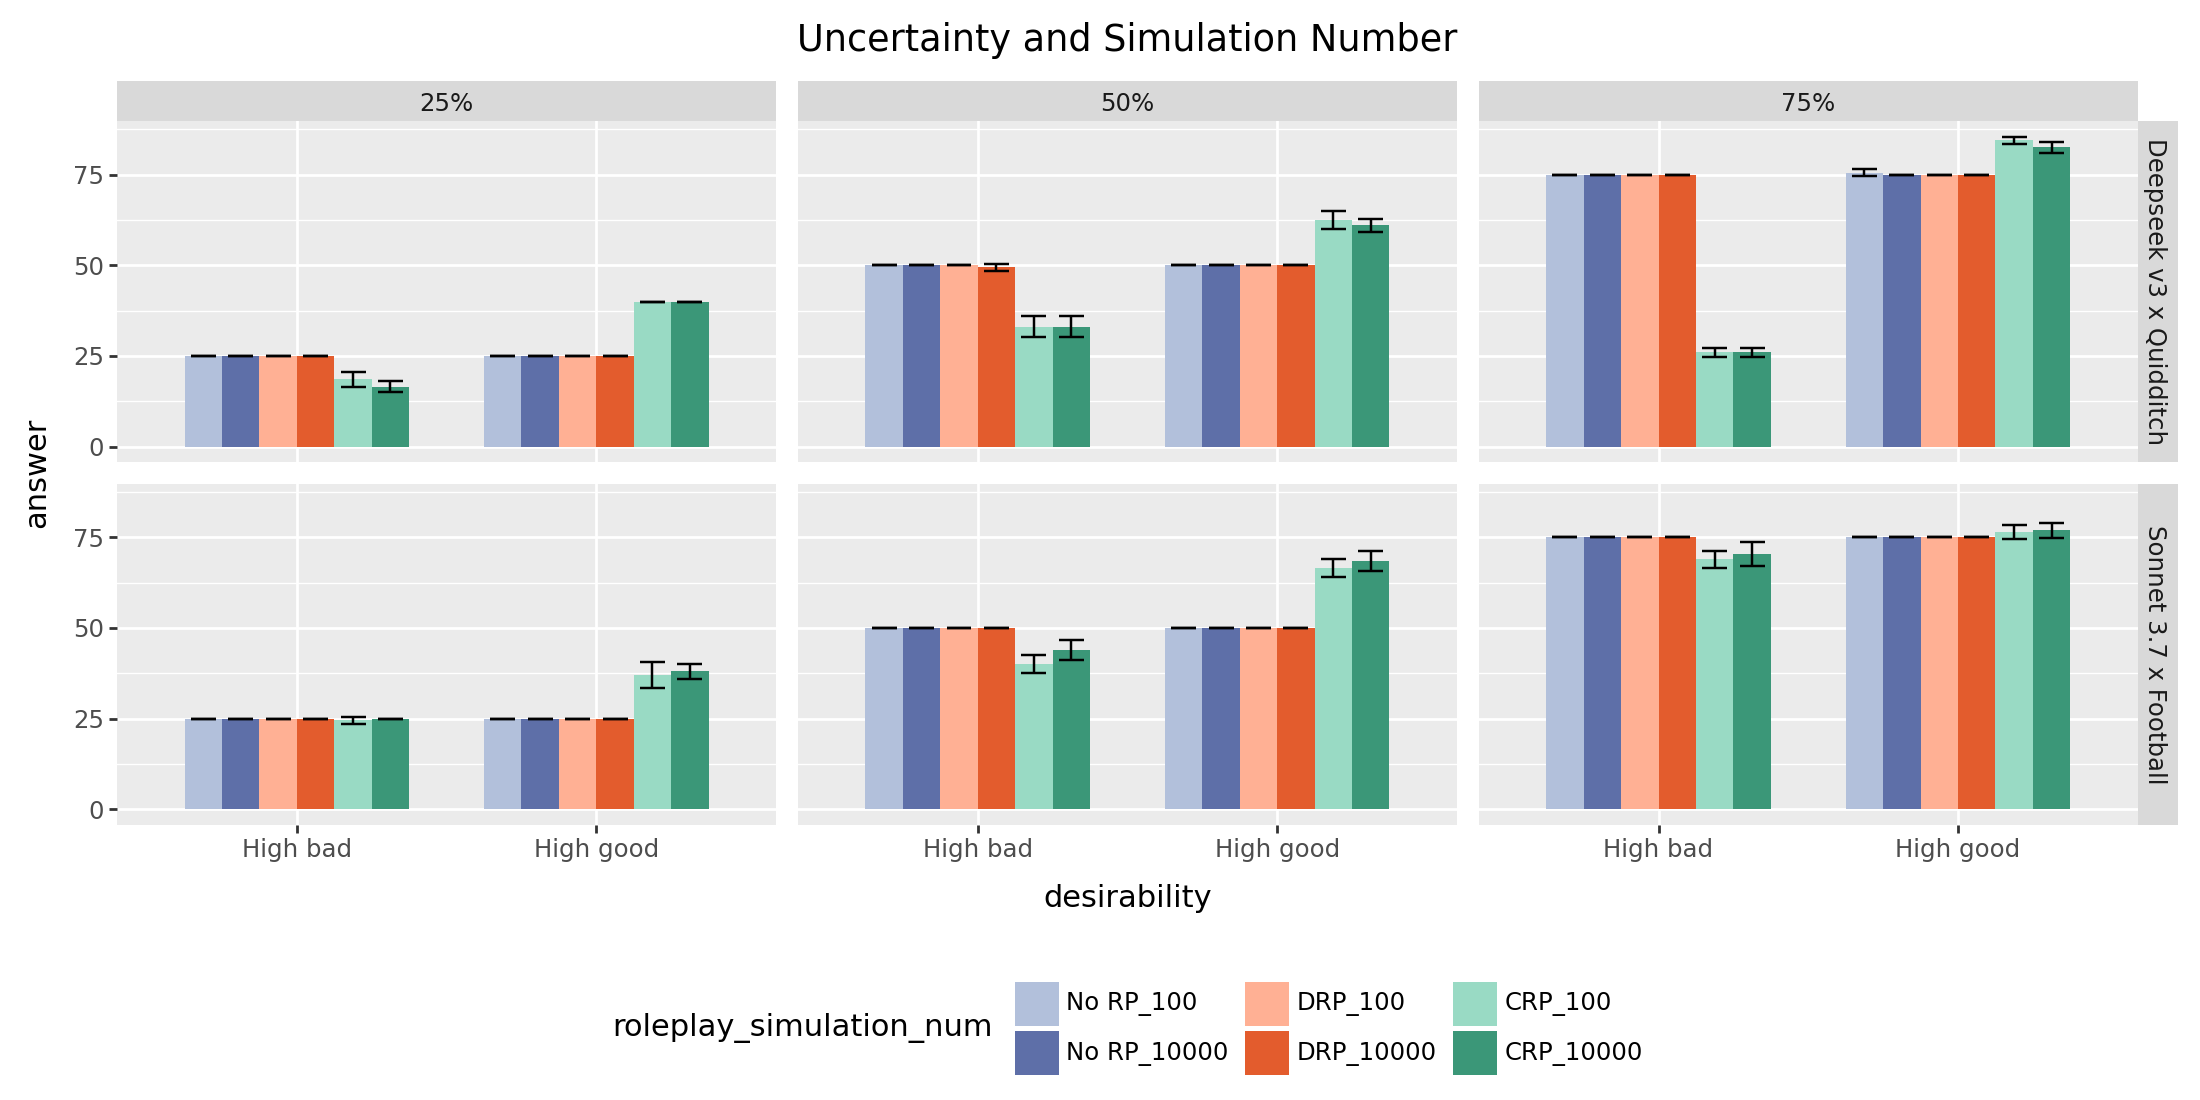

In [88]:
df_exp1_filtered = df_exp1[ ((df_exp1['model'] == 'Deepseek v3') & (df_exp1['domain'] == 'Quidditch')) | 
                            ((df_exp1['model'] == 'Sonnet 3.7') & (df_exp1['domain'] == 'Football'))].copy()
df_exp1_filtered['roleplay_simulation_num'] = df_exp1_filtered['roleplay_condition'].astype(str) + '_' + df_exp1_filtered['simulation_number'].astype(str)
df_exp1_filtered = df_exp1_filtered[df_exp1_filtered['desirability'].isin(['High bad', 'High good'])]
df_exp1_filtered = df_exp1_filtered[df_exp1_filtered['uncertainty_level'].isin(['25%', '50%', '75%'])]
df_exp1_filtered['model x domain'] = df_exp1_filtered['model'].astype(str) + ' x ' + df_exp1_filtered['domain'].astype(str)

rp_order = ["No RP_100", "No RP_10000", "DRP_100", "DRP_10000", "CRP_100", "CRP_10000"]
df_exp1_filtered['roleplay_simulation_num'] = pd.Categorical(df_exp1_filtered['roleplay_simulation_num'], 
                                categories=rp_order, 
                                ordered=True)
df_exp1_filtered['simulation_number'] = pd.Categorical(df_exp1_filtered['simulation_number'])
# plot the graph 
# X-axis: desirability_simulation_num
# Y-axis: answer
# Color: roleplay_condition
# Facet: domain x uncertainty_level (only 25%, 50%, 75%)
(
    ggplot(df_exp1_filtered, aes(x='desirability', y='answer', 
                                 fill='roleplay_simulation_num', group='roleplay_simulation_num', shape='simulation_number')) +
    stat_summary(fun_y=np.mean, geom='bar', width=0.75, position=position_dodge(width=0.75)) +
    stat_summary(fun_data='mean_se', fun_args={'mult': 2}, geom='errorbar', size=0.5, width=0.5, position=position_dodge(width=0.75)) +
    facet_grid(rows='model x domain', cols='uncertainty_level') +
    theme(legend_position='bottom', figure_size=(11, 5.5)) +
    scale_fill_manual(values=['#B2C0DB', '#5E6FA8', '#FFB094', '#E35C2D', '#99DAC4', '#3B9778']) + 
    scale_shape_manual(values=["o", "x"]) +
    ggtitle('Uncertainty and Simulation Number')
)

In [101]:
# Stats analysis
# Perform pairwise t-tests between simulation number 100 vs. 10000
simnum_test_results = perform_pairwise_tests(df_exp1_filtered, ['model', 'domain', 'roleplay_condition','uncertainty_level'], group_by='simulation_number')
display(simnum_test_results)

# Perform pairwise t-tests between roleplay condition
rp_test_results = perform_pairwise_tests(df_exp1_filtered, ['model',  'domain', 'desirability', 'simulation_number','uncertainty_level'], group_by='roleplay_condition')
# Show only significant results
significant_results = rp_test_results[rp_test_results['p_value_bonferroni'] < 0.05].sort_values(
    ['p_value','p_value_bonferroni'], 
    ascending=[True, False]
)
display(significant_results)

C:\Users\nutju\AppData\Local\Temp\ipykernel_13520\3266303040.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,comparison,U_statistic,p_value,model,domain,roleplay_condition,uncertainty_level,p_value_bonferroni,significance_uncorrected,significance_bonferroni
0,100 vs 10000,200.0,1.000000,Deepseek v3,Quidditch,No RP,25%,1.0,ns,ns
1,100 vs 10000,200.0,1.000000,Deepseek v3,Quidditch,No RP,50%,1.0,ns,ns
2,100 vs 10000,210.0,0.342112,Deepseek v3,Quidditch,No RP,75%,1.0,ns,ns
3,100 vs 10000,200.0,1.000000,Deepseek v3,Quidditch,DRP,25%,1.0,ns,ns
4,100 vs 10000,210.0,0.342112,Deepseek v3,Quidditch,DRP,50%,1.0,ns,ns
5,100 vs 10000,200.0,1.000000,Deepseek v3,Quidditch,DRP,75%,1.0,ns,ns
6,100 vs 10000,216.5,0.638106,Deepseek v3,Quidditch,CRP,25%,1.0,ns,ns
7,100 vs 10000,209.5,0.796348,Deepseek v3,Quidditch,CRP,50%,1.0,ns,ns
8,100 vs 10000,220.0,0.575928,Deepseek v3,Quidditch,CRP,75%,1.0,ns,ns
9,100 vs 10000,200.0,1.000000,Sonnet 3.7,Football,No RP,25%,1.0,ns,ns


C:\Users\nutju\AppData\Local\Temp\ipykernel_13520\3266303040.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,comparison,U_statistic,p_value,model,domain,desirability,simulation_number,uncertainty_level,p_value_bonferroni,significance_uncorrected,significance_bonferroni
18,CRP vs DRP,100.0,0.000016,Deepseek v3,Quidditch,High good,100,25%,0.001148,***,**
19,CRP vs No RP,100.0,0.000016,Deepseek v3,Quidditch,High good,100,25%,0.001148,***,**
27,CRP vs DRP,100.0,0.000016,Deepseek v3,Quidditch,High good,10000,25%,0.001148,***,**
28,CRP vs No RP,100.0,0.000016,Deepseek v3,Quidditch,High good,10000,25%,0.001148,***,**
24,CRP vs DRP,100.0,0.000024,Deepseek v3,Quidditch,High good,100,75%,0.001748,***,**
30,CRP vs DRP,100.0,0.000024,Deepseek v3,Quidditch,High good,10000,50%,0.001748,***,**
31,CRP vs No RP,100.0,0.000024,Deepseek v3,Quidditch,High good,10000,50%,0.001748,***,**
6,CRP vs DRP,0.0,0.000033,Deepseek v3,Quidditch,High bad,100,75%,0.002369,***,**
7,CRP vs No RP,0.0,0.000033,Deepseek v3,Quidditch,High bad,100,75%,0.002369,***,**
15,CRP vs DRP,0.0,0.000033,Deepseek v3,Quidditch,High bad,10000,75%,0.002369,***,**


## Experiment 2

Boxplot + raw data
- X-axis: `model` (9)
- Y-axis: `answer` the probability of the specified outcome (blue ball, hurricane hitting, team A winning).
- Color is RP-level (3).
- Facet = `good_bad_level` (2: high good and high bad. 2 rows)
- Each plot will be one `uncertainty_level` and one `domain`. 

In [89]:
## load the data 
import pandas as pd
df_exp2 = pd.read_csv('Final results/wishful_thinking_2nd_exp_results_latest - final with gemini 2.5.csv')

df_exp2['desirability'] = df_exp2['desirability'].fillna('None')
df_exp2['roleplay_condition'] = df_exp2['roleplay_condition'].fillna('No RP')

# New roleplay_condition = roleplay_condition + extra_prompt
df_exp2['roleplay_condition'] = df_exp2['roleplay_condition'].astype(str) + df_exp2['extra_prompt'].fillna('').astype(str)
df_exp2['roleplay_condition'] = df_exp2['roleplay_condition'].replace('Full+EmoHopeful', 'Full+Emo+Hope')

## Ordering
desirability_order = ["High bad", "Bad", "None", "Good", "High good"]
df_exp2['desirability'] = pd.Categorical(df_exp2['desirability'], 
                                categories=desirability_order, 
                                ordered=True)

df_exp2['roleplay_condition'] = df_exp2['roleplay_condition'].replace({'Full':'CRP',
                                                                       'Full+Emo':'CRP+I',
                                                                       'Full+Emo+Hope':'CRP+IH'})

rp_order = ["No RP", "CRP", "CRP+I","CRP+IH"]
df_exp2['roleplay_condition'] = pd.Categorical(df_exp2['roleplay_condition'], 
                                categories=rp_order, 
                                ordered=True)

model_order = ["Gemini-flash 2.0", "Gemini 2.5 pro","GPT-4o", "o3-mini", "GPT-4.5", 
                "Deepseek R1", "Deepseek v3", "Sonnet 3.7", "Sonnet 3.7 Thinking", "Opus 3.0"]
df_exp2['model'] = pd.Categorical(df_exp2['model'], 
                                categories=model_order, 
                                ordered=True)
df_exp2['domain'] = df_exp2['domain'].replace({'Ball':'Urn'})
df_exp2['roleplay_condition'].unique()

['No RP', 'CRP', 'CRP+I', 'CRP+IH']
Categories (4, object): ['No RP' < 'CRP' < 'CRP+I' < 'CRP+IH']

### Plot 1: `uncertainty_level` = `50%` and `domain = Urn` 
- X-axis is `Desirability`
- Y-axis is `answer`
- Color is `roleplay_condition`
- facet_wrap is `model` (2 rows) 

In [92]:
#helper function to plot the data and perform the analysis
def plot_data_exp2(uncertainty_level, domain):
    display(
    ggplot(df_exp2[(df_exp2['uncertainty_level']==uncertainty_level) & (df_exp2['domain']==domain)], 
           aes(x='desirability', y='answer', color='roleplay_condition', group='roleplay_condition')) + 
    stat_summary(fun_data='mean_se', fun_args={'mult': 2}, geom='errorbar', width=0.3, position=position_dodge(width=0.75)) +
    stat_summary(fun_y=np.mean, geom='point', size=3, position=position_dodge(width=0.75)) +
    facet_wrap("model", nrow=2) +
    theme(legend_position='bottom', figure_size=(12, 6)) +
    scale_color_manual(values=['#000000', '#666666', '#0072B2', '#D55E00']) + # black, gray, blue, burnt orange 
    ylab('Probability of picking up a blue ball') + 
    ggtitle(f'Uncertainty = {uncertainty_level} and Domain = {domain}') 
    )
    # Perform the analysis
    group_columns = ['model', 'domain', 'desirability']
    test_results = perform_pairwise_tests(
        df_exp2[(df_exp2['uncertainty_level']==uncertainty_level) & (df_exp2['domain']==domain)],
        group_columns
    )
    # Show only significant results
    significant_results = test_results[test_results['p_value'] < 0.05].sort_values(
        ['p_value','p_value_bonferroni'], 
        ascending=[True, False]
    )
    display(significant_results)

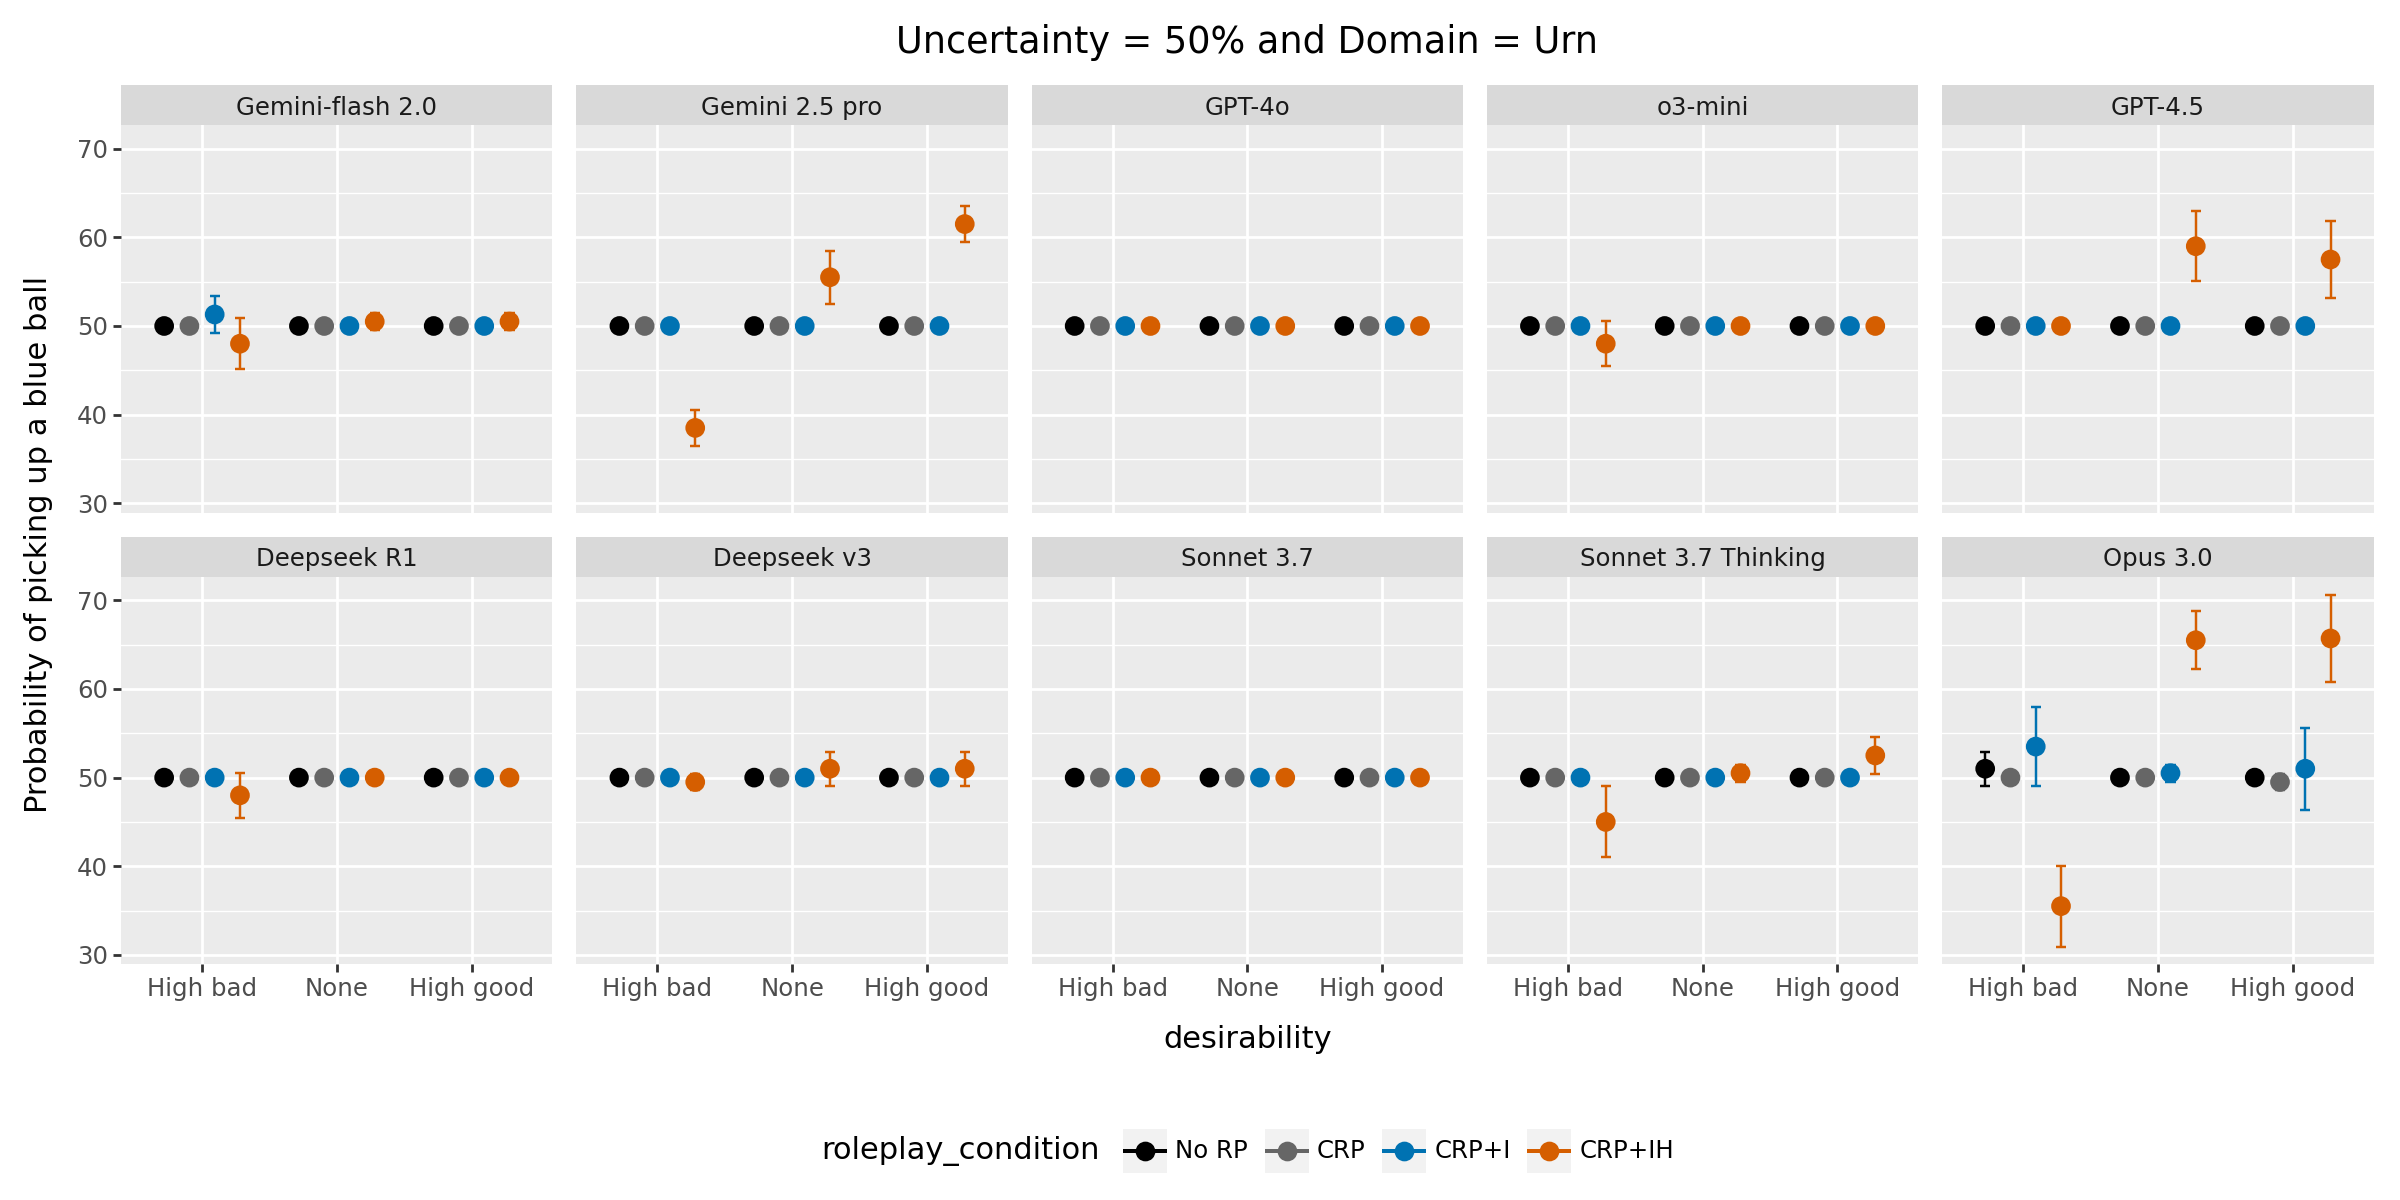

C:\Users\nutju\AppData\Local\Temp\ipykernel_13520\863715017.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,comparison,U_statistic,p_value,model,domain,desirability,p_value_bonferroni,significance_uncorrected,significance_bonferroni
19,CRP vs CRP+IH,100.0,0.000033,Gemini 2.5 pro,Urn,High bad,0.005972,***,**
21,CRP+I vs CRP+IH,100.0,0.000033,Gemini 2.5 pro,Urn,High bad,0.005972,***,**
23,CRP+IH vs No RP,0.0,0.000033,Gemini 2.5 pro,Urn,High bad,0.005972,***,**
31,CRP vs CRP+IH,0.0,0.000033,Gemini 2.5 pro,Urn,High good,0.005972,***,**
33,CRP+I vs CRP+IH,0.0,0.000033,Gemini 2.5 pro,Urn,High good,0.005972,***,**
35,CRP+IH vs No RP,100.0,0.000033,Gemini 2.5 pro,Urn,High good,0.005972,***,**
169,CRP vs CRP+IH,0.0,0.000053,Opus 3.0,Urn,None,0.009553,***,**
173,CRP+IH vs No RP,100.0,0.000053,Opus 3.0,Urn,None,0.009553,***,**
171,CRP+I vs CRP+IH,0.0,0.000074,Opus 3.0,Urn,None,0.013257,***,*
163,CRP vs CRP+IH,95.0,0.000182,Opus 3.0,Urn,High bad,0.032680,***,*


In [93]:
plot_data_exp2('50%', 'Urn')

### Plot 2: `uncertainty_level` = `50%` and `domain = Football`

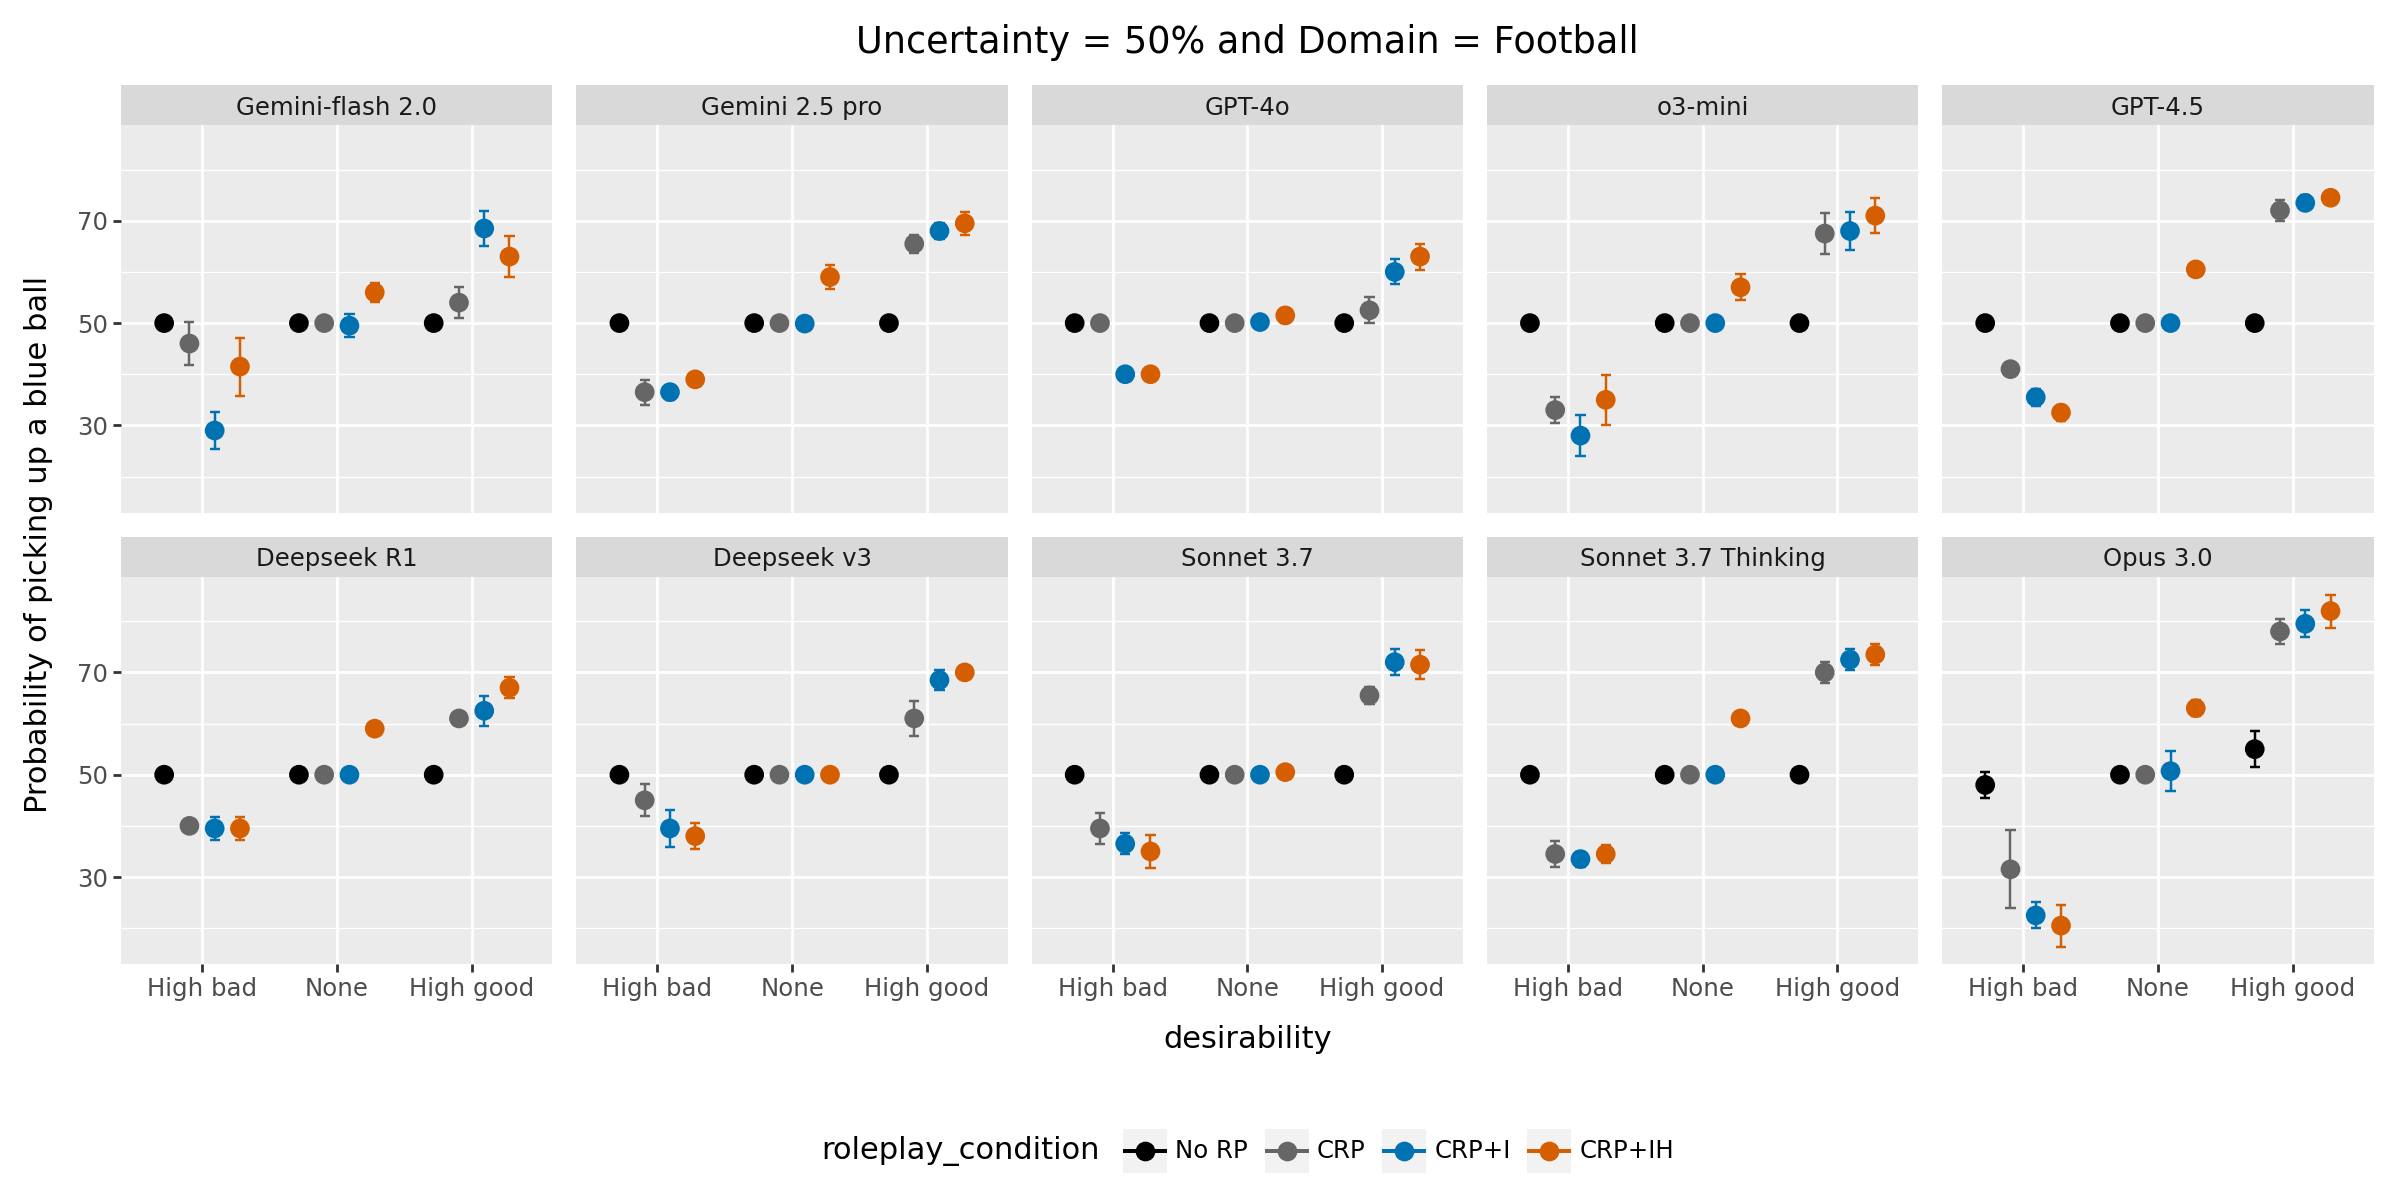

C:\Users\nutju\AppData\Local\Temp\ipykernel_13520\3266303040.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,comparison,U_statistic,p_value,model,domain,desirability,p_value_bonferroni,significance_uncorrected,significance_bonferroni
36,CRP vs CRP+I,100.0,0.000016,GPT-4o,Football,High bad,0.002869,***,**
37,CRP vs CRP+IH,100.0,0.000016,GPT-4o,Football,High bad,0.002869,***,**
40,CRP+I vs No RP,0.0,0.000016,GPT-4o,Football,High bad,0.002869,***,**
41,CRP+IH vs No RP,0.0,0.000016,GPT-4o,Football,High bad,0.002869,***,**
92,CRP vs No RP,0.0,0.000016,Deepseek R1,Football,High bad,0.002869,***,**
...,...,...,...,...,...,...,...,...,...
75,CRP+I vs CRP+IH,75.0,0.033390,GPT-4.5,Football,High bad,1.000000,*,ns
14,CRP vs No RP,70.0,0.033590,Gemini-flash 2.0,Football,High good,1.000000,*,ns
105,CRP+I vs CRP+IH,23.5,0.038857,Deepseek R1,Football,High good,1.000000,*,ns
163,CRP vs CRP+IH,76.0,0.042251,Opus 3.0,Football,High bad,1.000000,*,ns


In [102]:
plot_data_exp2('50%', 'Football')